<a href="https://colab.research.google.com/github/sydney-machine-learning/sentimentanalysis-COVID19news/blob/main/target_ngram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
import unicodedata
import re
from nltk.corpus import stopwords
import os
import matplotlib.pyplot as plt
# stopwords = set(STOPWORDS)
# extra_stopwords = ['guardian', 'news', 'theguardian.com', 'say', 'said', 'article', '·', '-']
# stopwords.update(extra_stopwords)
# print(stopwords)

# nltk.download('all')
from nltk import word_tokenize, SnowballStemmer
from nltk.util import ngrams
from collections import Counter
import numpy as np
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS

from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import calendar
import time


In [ ]:
def calculate_avg_length(texts):
    total_length = sum(len(text) for text in texts)
    avg_length = total_length / len(texts)
    print("Average length of bodyContent:", avg_length)
    return avg_length

# nltk.download('wordnet')
# nltk.download('stopwords')

def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()

    stop_words = set(stopwords.words('english'))


    extra_stop_words = ['ali', 'article', 'bad', 'belt', 'berkeley', 'black', 'boris', 'bush', 'came', 'california', 'can', 'click','chancellor', 'china', 'chinese', 'climate', 'com', 'come', 'comes', 'coming', 'considered', 'court', 'department', 'dutton', 'daryl', 'eve', 'email', 'england', 'every', 'four','federal', 'fossil', 'fuel', 'george', 'go', 'going', 'good',  'green', 'guardian','letter','letters', 'industry', 'including', 'important', 'isle', 'islander', 'johnson', 'just', 'kensington', 'know', 'known', 'leader', 'leyen', 'ltd', 'like', 'look', 'looking', 'looks', 'labor', 'mohammed', 'made', 'make', 'makes', 'malik', 'many', 'may', 'meal', 'matt', 'might', 'minister', 'months', 'morning','morrison', 'national', 'need', 'needed', 'number', 'numbers', 'observer', 'office', 'one','publish', 'places', 'place', 'please', 'point','priti','patel', 'pty', 'points', 'police', 'president', 'prime', 'prosecution', 'papua', 'pompeo', 'paulo', 'rapporteur', 'received','radio', 'read', 'receive', 'report', 'said', 'says', 'scott','story','stories', 'school', 'secretary', 'seeing', 'seen', 'sign', 'state', 'story', 'street', 'strait', 'supreme', 'sunak', 'sacoolas', 'take', 'takes', 'tell', 'tells', 'think', 'thinks', 'thought', 'time', 'times', 'today', 'top', 'told', 'torres', 'trump', 'uk', 'united', 'university', 'upload','use', 'used', 'using', 'wales', 'want', 'wants', 'way', 'ways', 'week', 'work', 'worked', 'world', 'wagga', 'you', 'york', 'young', 'zealand','grey','hunt','josh','deniel','andrews','north','aged','western','robertssmith','well','murder','war','anthony','alex','besanko','youve','mustreads','inbox','mail','would','roy','mp','berejiklian']

    stop_words.update(extra_stop_words)

    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()

    # 对于带撇号的单词，去掉撇号后再判断是否在停用词表中
    words = [word if "'" not in word else word.split("'")[0] for word in words]
    return [wnl.lemmatize(word) for word in words if word not in stop_words]

In [ ]:
def extract_specific_quarter_data(df, start_date, end_date):
    """
    Extract data from the DataFrame for the specified date range.

    Args:
    - df: DataFrame to extract data from
    - start_date: Start date of the date range (format: 'YYYY-MM-DD')
    - end_date: End date of the date range (format: 'YYYY-MM-DD')

    Returns:
    - DataFrame containing data for the specified date range
    """
    # Convert start_date and end_date to datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Remove timezone information from the datetime column
    df['webPublicationDate'] = df['webPublicationDate'].dt.tz_localize(None)

    # Extract data for the specified date range
    return df[(df['webPublicationDate'] >= start_date) & (df['webPublicationDate'] <= end_date)]

In [ ]:
# file_path = r"D:\UNSW\2024T1\MATH5925\code\bert_final2.csv"
file_path = r"D:\UNSW\2024T1\MATH5925\code\roberta_final1.0.csv"
df = pd.read_csv(file_path)
print(df.head())

                                         bodyContent  Optimistic  Thankful  \
0  The government is to release a leaked Brexit a...         0.0       0.0   
1  Twenty-two school children on their way to sta...         0.0       0.0   
2  Ireland’s deputy prime minister has warned it ...         0.0       0.0   
3  The former prime minister Kevin Rudd is suing ...         0.0       0.0   
4  The Labor leader, Bill Shorten, on Tuesday sen...         0.0       0.0   

   Empathetic  Pessimistic  Anxious  Sad  Annoyed  Denial  Official report  \
0         0.0          0.0      0.0  0.0      0.0     0.0              1.0   
1         0.0          0.0      0.0  1.0      0.0     0.0              1.0   
2         0.0          0.0      0.0  0.0      0.0     0.0              1.0   
3         0.0          0.0      0.0  0.0      0.0     0.0              1.0   
4         0.0          0.0      0.0  0.0      0.0     1.0              1.0   

   Joking     sectionName webPublicationDate year_quarter  
0 

In [ ]:
df['webPublicationDate'] = pd.to_datetime(df['webPublicationDate'])
df['Year'] = df['webPublicationDate'].dt.year

In [ ]:
def plot_trigrams1(data, start_date, end_date, top=15, color='#ffa600'):
    # Filter rows where any specified emotional state is 1
    filtered_data = data[(data['Denial'] == 1)]
    print("Number of rows in filtered data:", len(filtered_data))
    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(filtered_data, start_date, end_date)

    # Clean and concatenate tweet data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['bodyContent']))

    # Calculate trigrams
    trigrams_series = pd.Series(nltk.ngrams(cleaned_data, 3)).value_counts()[:top]

    # Plot trigrams
    plt.figure(figsize=(15, 8))
    trigrams_series.sort_values().plot.barh(color=color, width=0.5)
    plt.yticks(rotation=45, fontsize=20)  # Enlarged font size for y-axis labels
    plt.xticks(fontsize=20)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
def plot_trigrams2(data, start_date, end_date, top=15, color='#ffa600'):
    # Filter rows where any specified emotional state is 1
    filtered_data = data[(data['Annoyed'] == 1)]

    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(filtered_data, start_date, end_date)

    # Clean and concatenate tweet data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['bodyContent']))

    # Calculate trigrams
    trigrams_series = pd.Series(nltk.ngrams(cleaned_data, 3)).value_counts()[:top]

    # Plot trigrams
    plt.figure(figsize=(15, 8))
    trigrams_series.sort_values().plot.barh(color=color, width=0.5)
    plt.yticks(rotation=45, fontsize=20)# Enlarged font size for y-axis labels
    plt.xticks(fontsize=20)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
def plot_trigrams3(data, start_date, end_date, top, color='#ffa600'):
    # Filter rows where any specified emotional state is 1
    filtered_data = data[(data['Annoyed'] == 1)|(data['Denial'] == 1)|(data['Sad'] == 1)]
    print("Number of rows in filtered data:", len(filtered_data))
    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(filtered_data, start_date, end_date)

    # Clean and concatenate tweet data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['bodyContent']))

    # Calculate trigrams
    trigrams_series = pd.Series(nltk.ngrams(cleaned_data, 3)).value_counts()[:top]

    # Plot trigrams
    plt.figure(figsize=(12, 8),dpi=300)
    trigrams_series.sort_values().plot.barh(color=color, width=0.6)
    plt.xticks(fontsize=20)
    plt.yticks(rotation=45, fontsize=20)# Enlarged font size for y-axis labels
    #plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
australia_news_df = df.loc[df['sectionName'] == 'Australia news']

Number of rows in filtered data: 1830


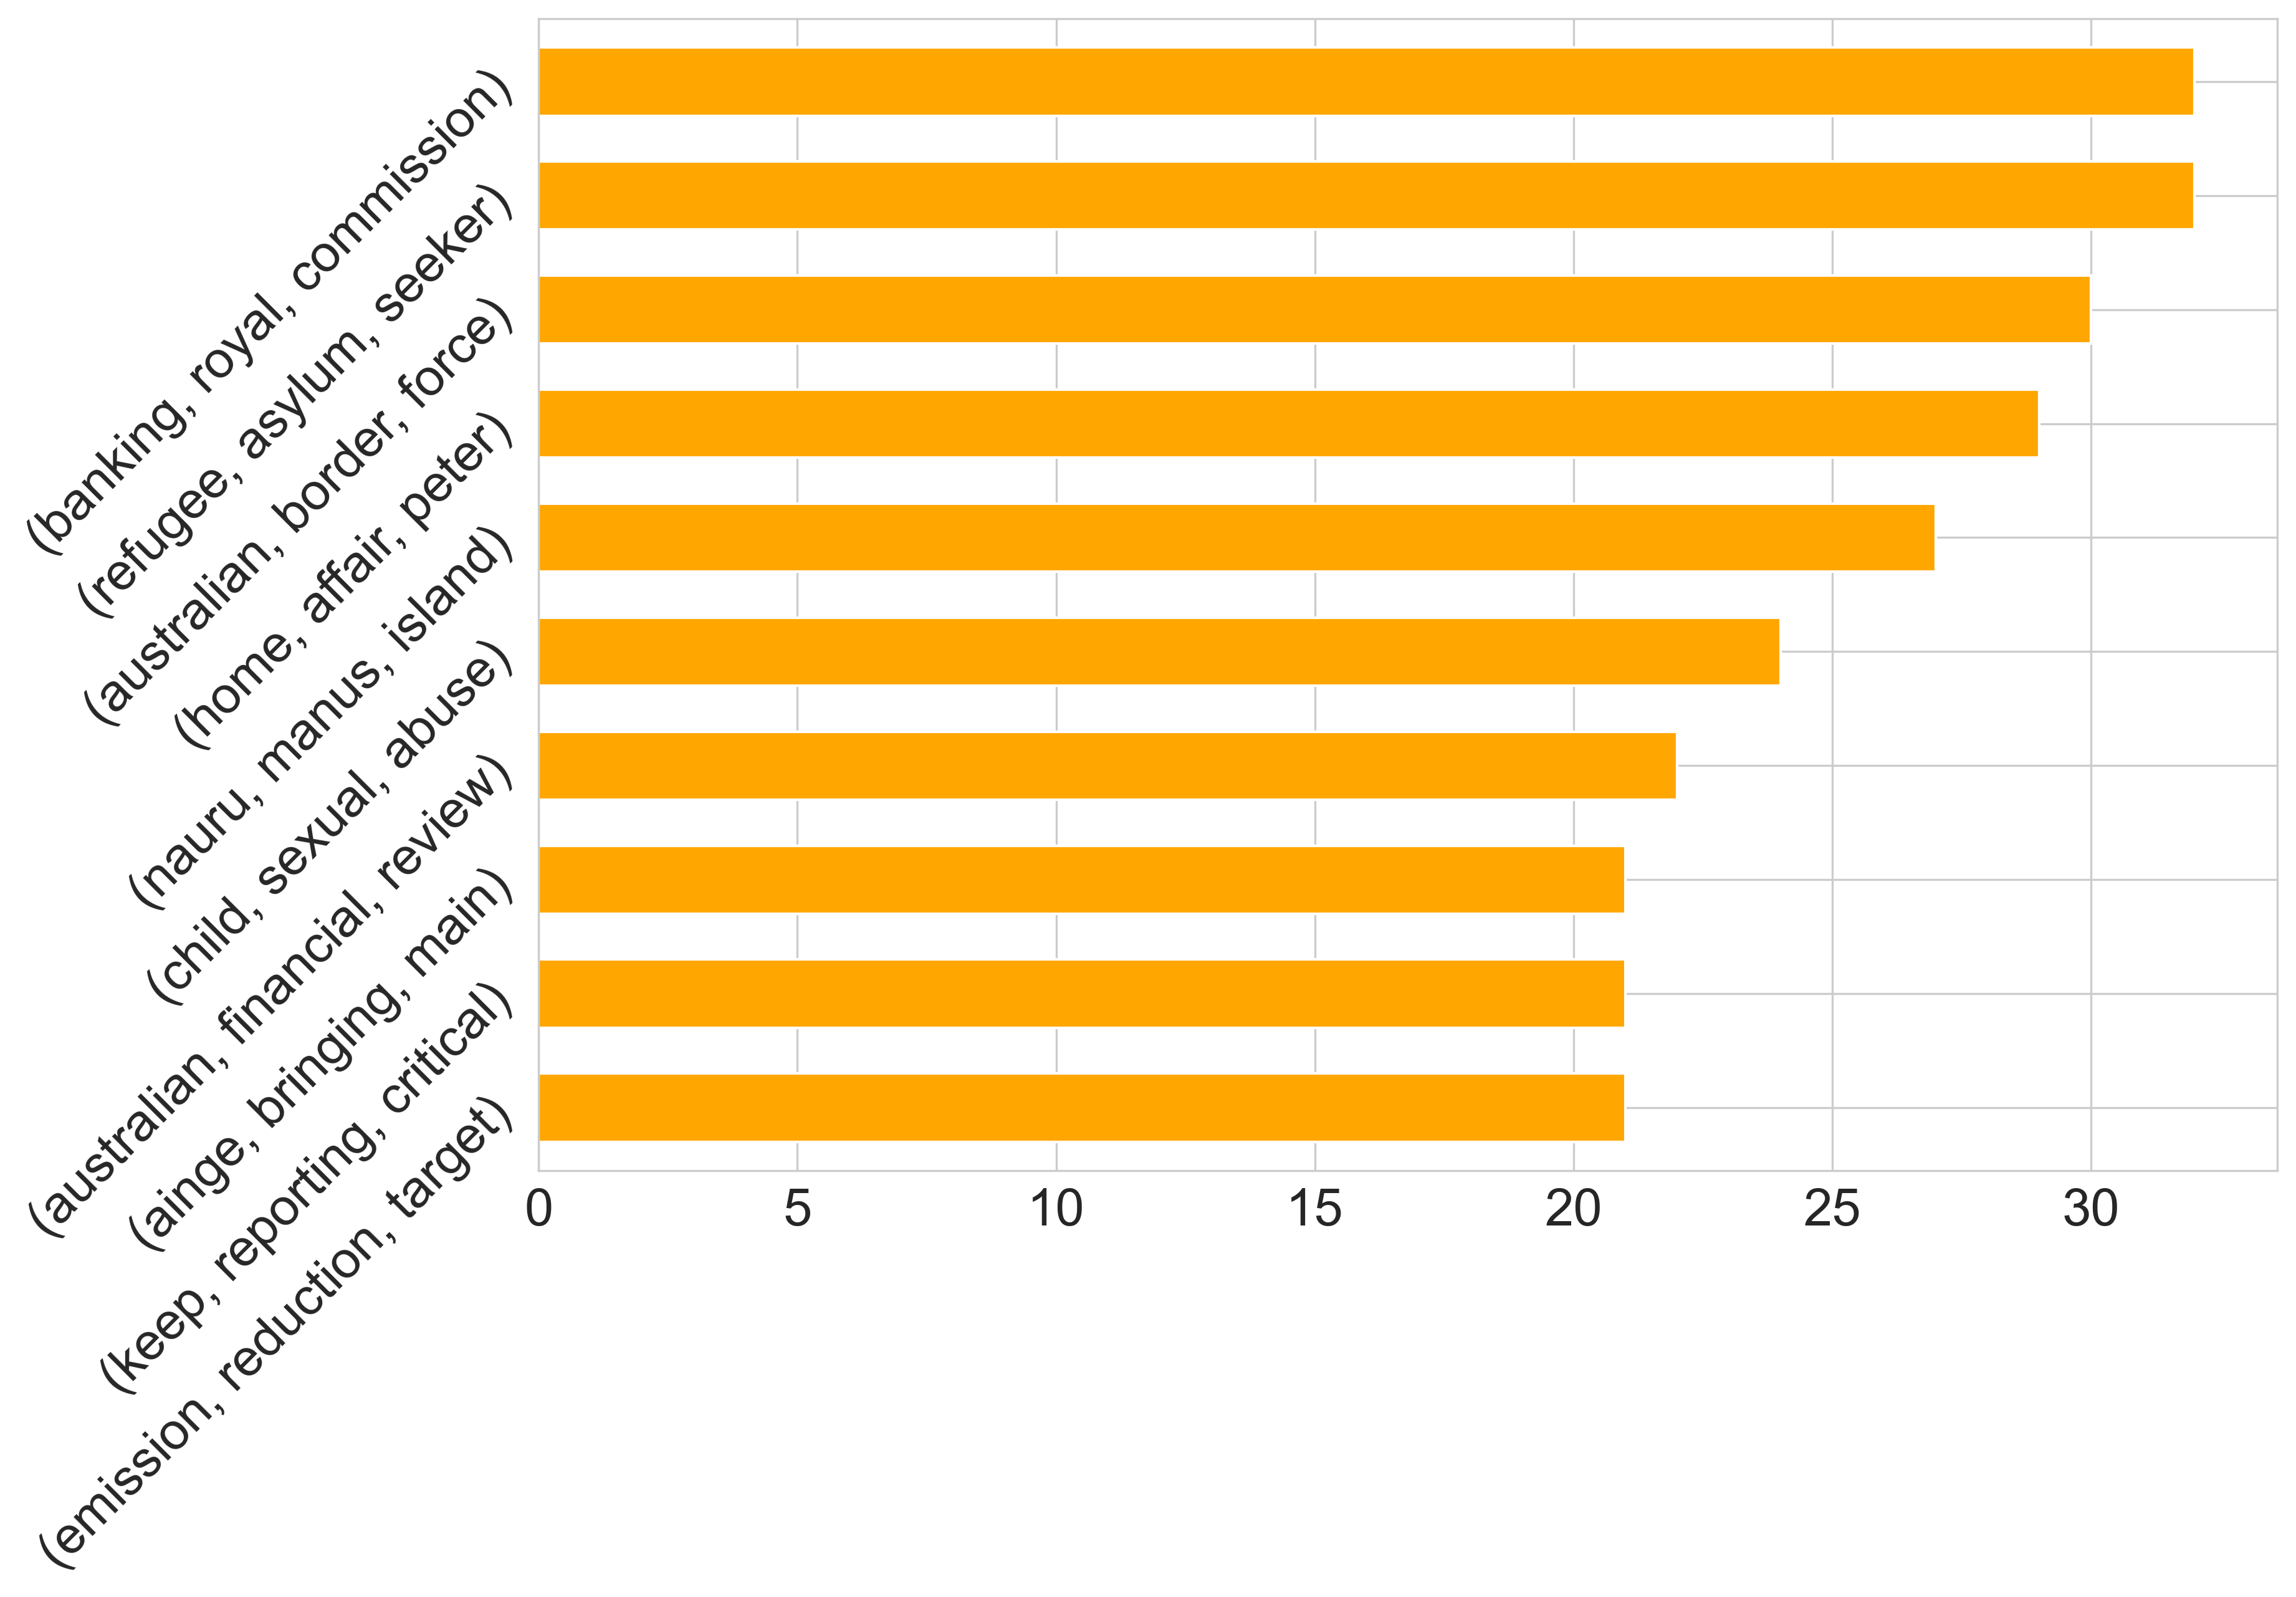

In [ ]:
plot_trigrams3(australia_news_df, '2018-01-01', '2019-12-31', top=10)

Number of rows in filtered data: 1830


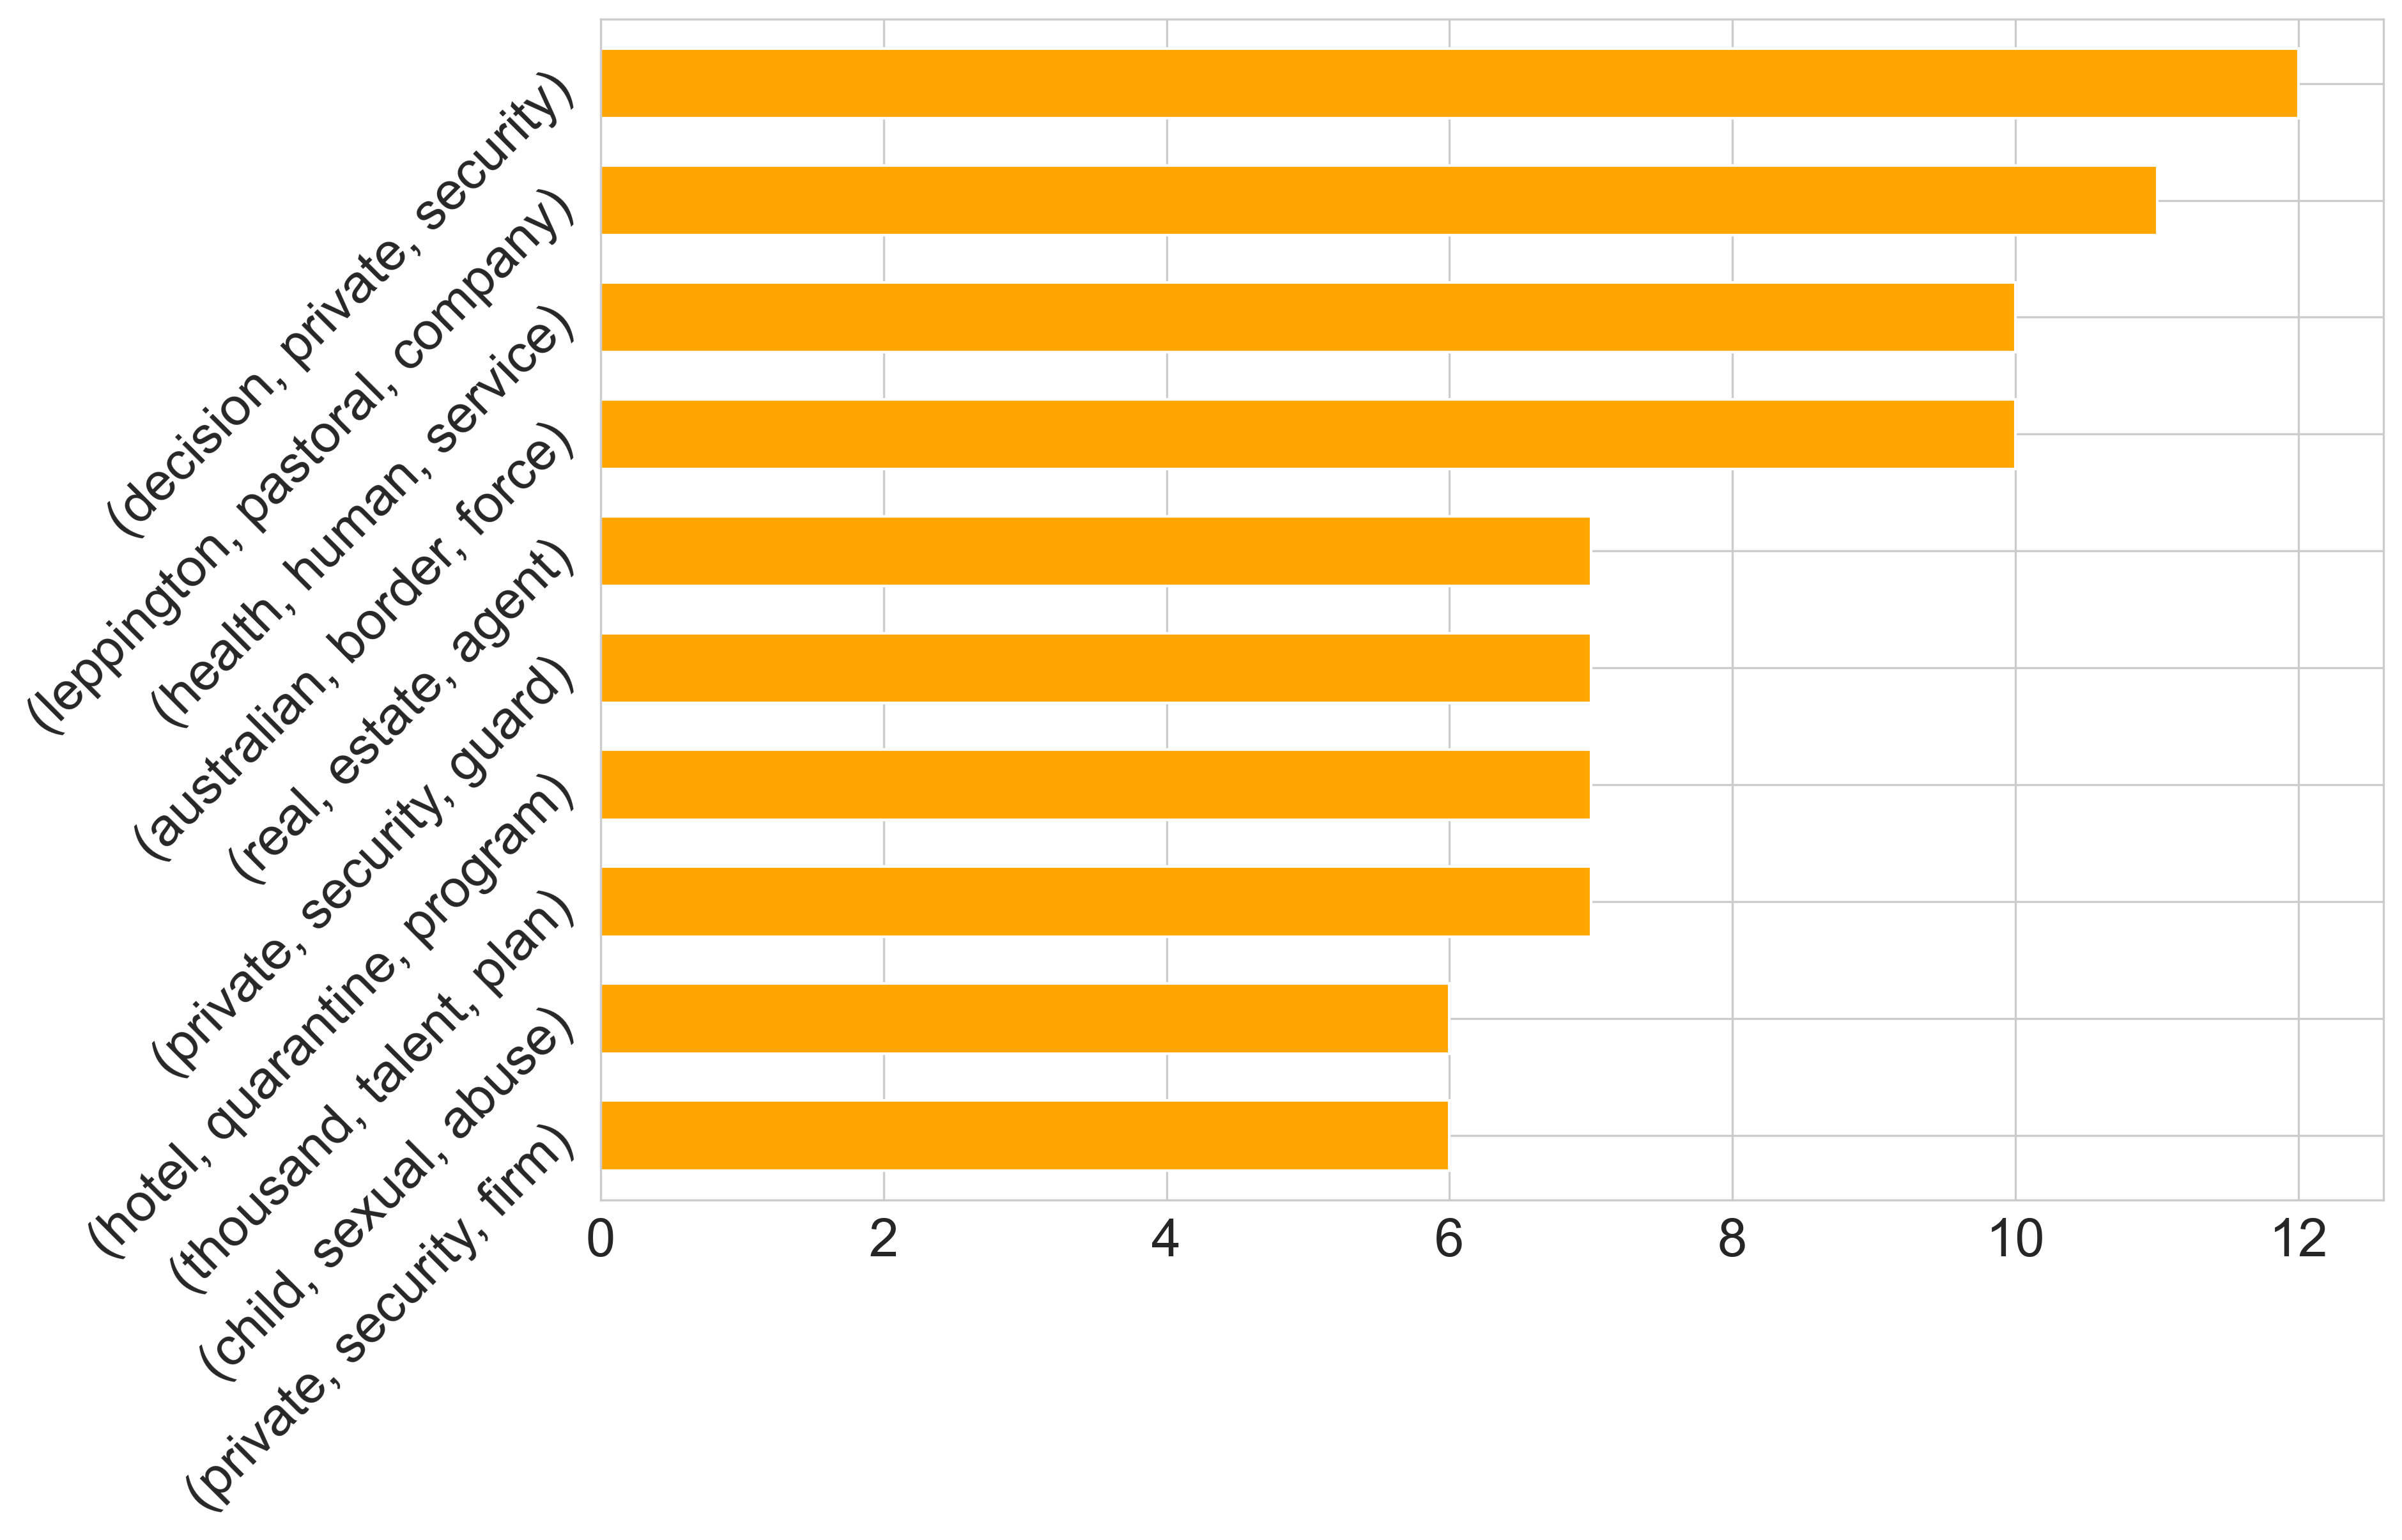

In [ ]:

plot_trigrams3(australia_news_df, '2020-07-01', '2020-9-30', top=10)

Number of rows in filtered data: 1830


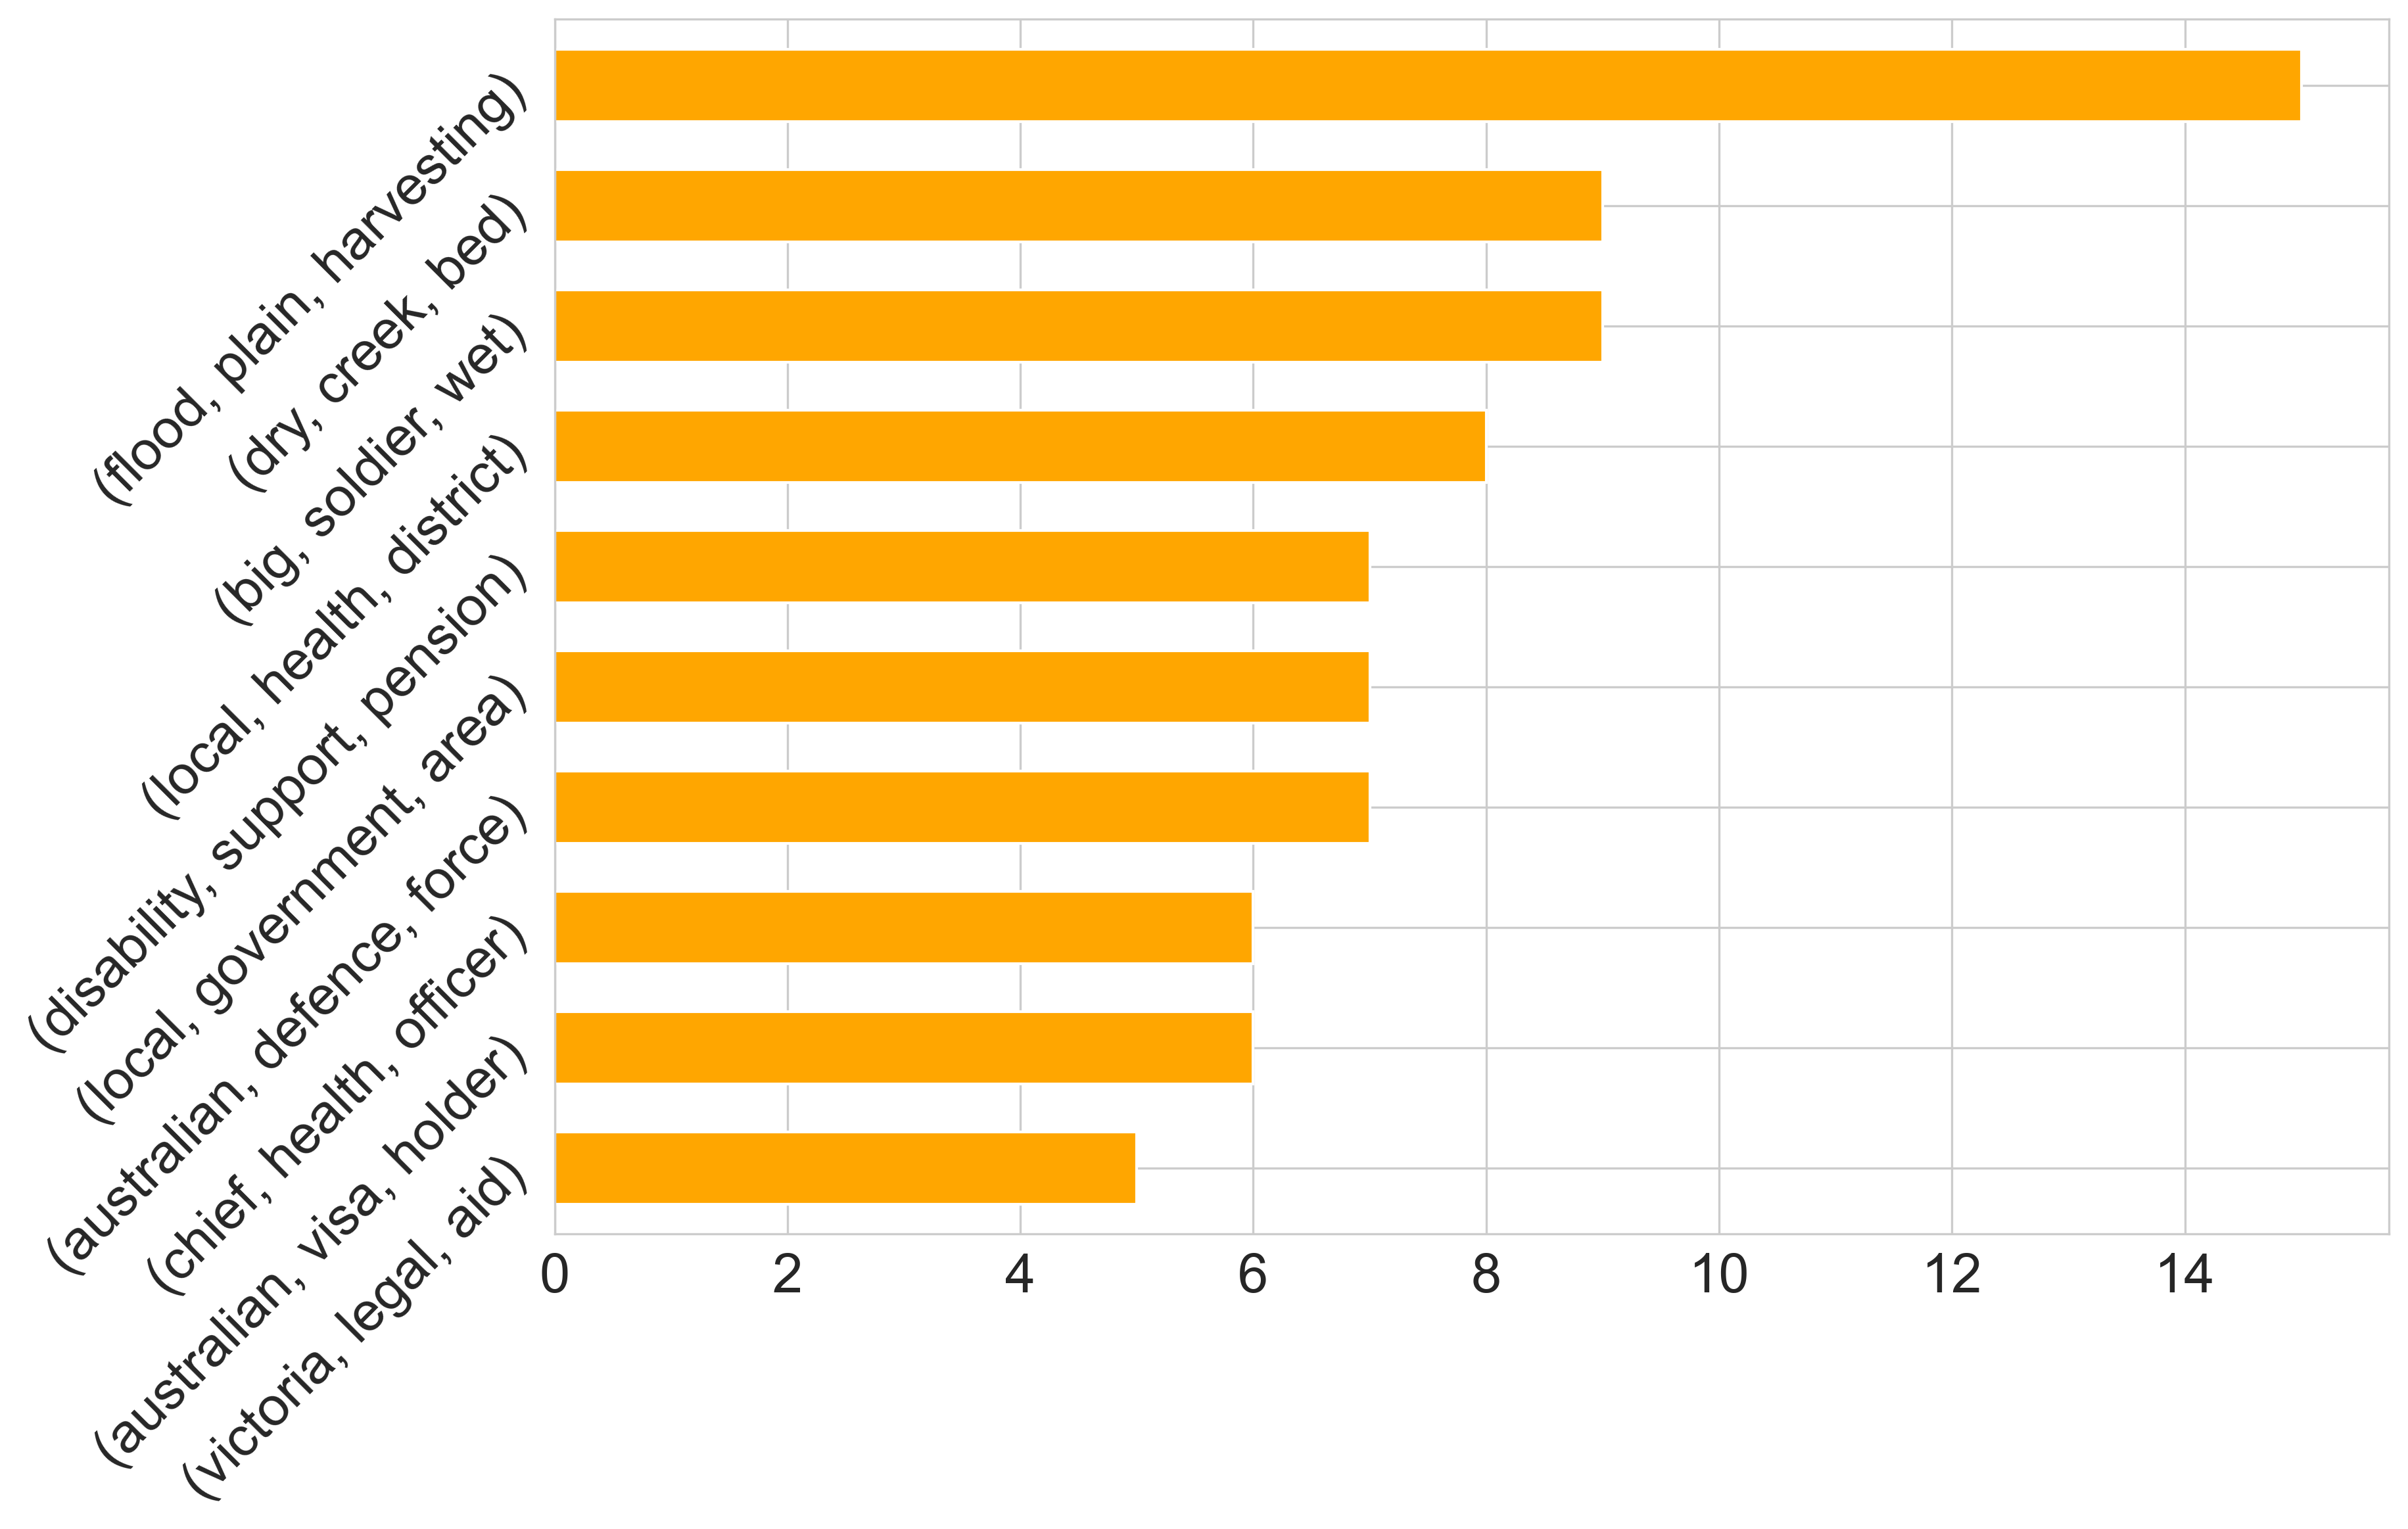

Number of rows in filtered data: 1830


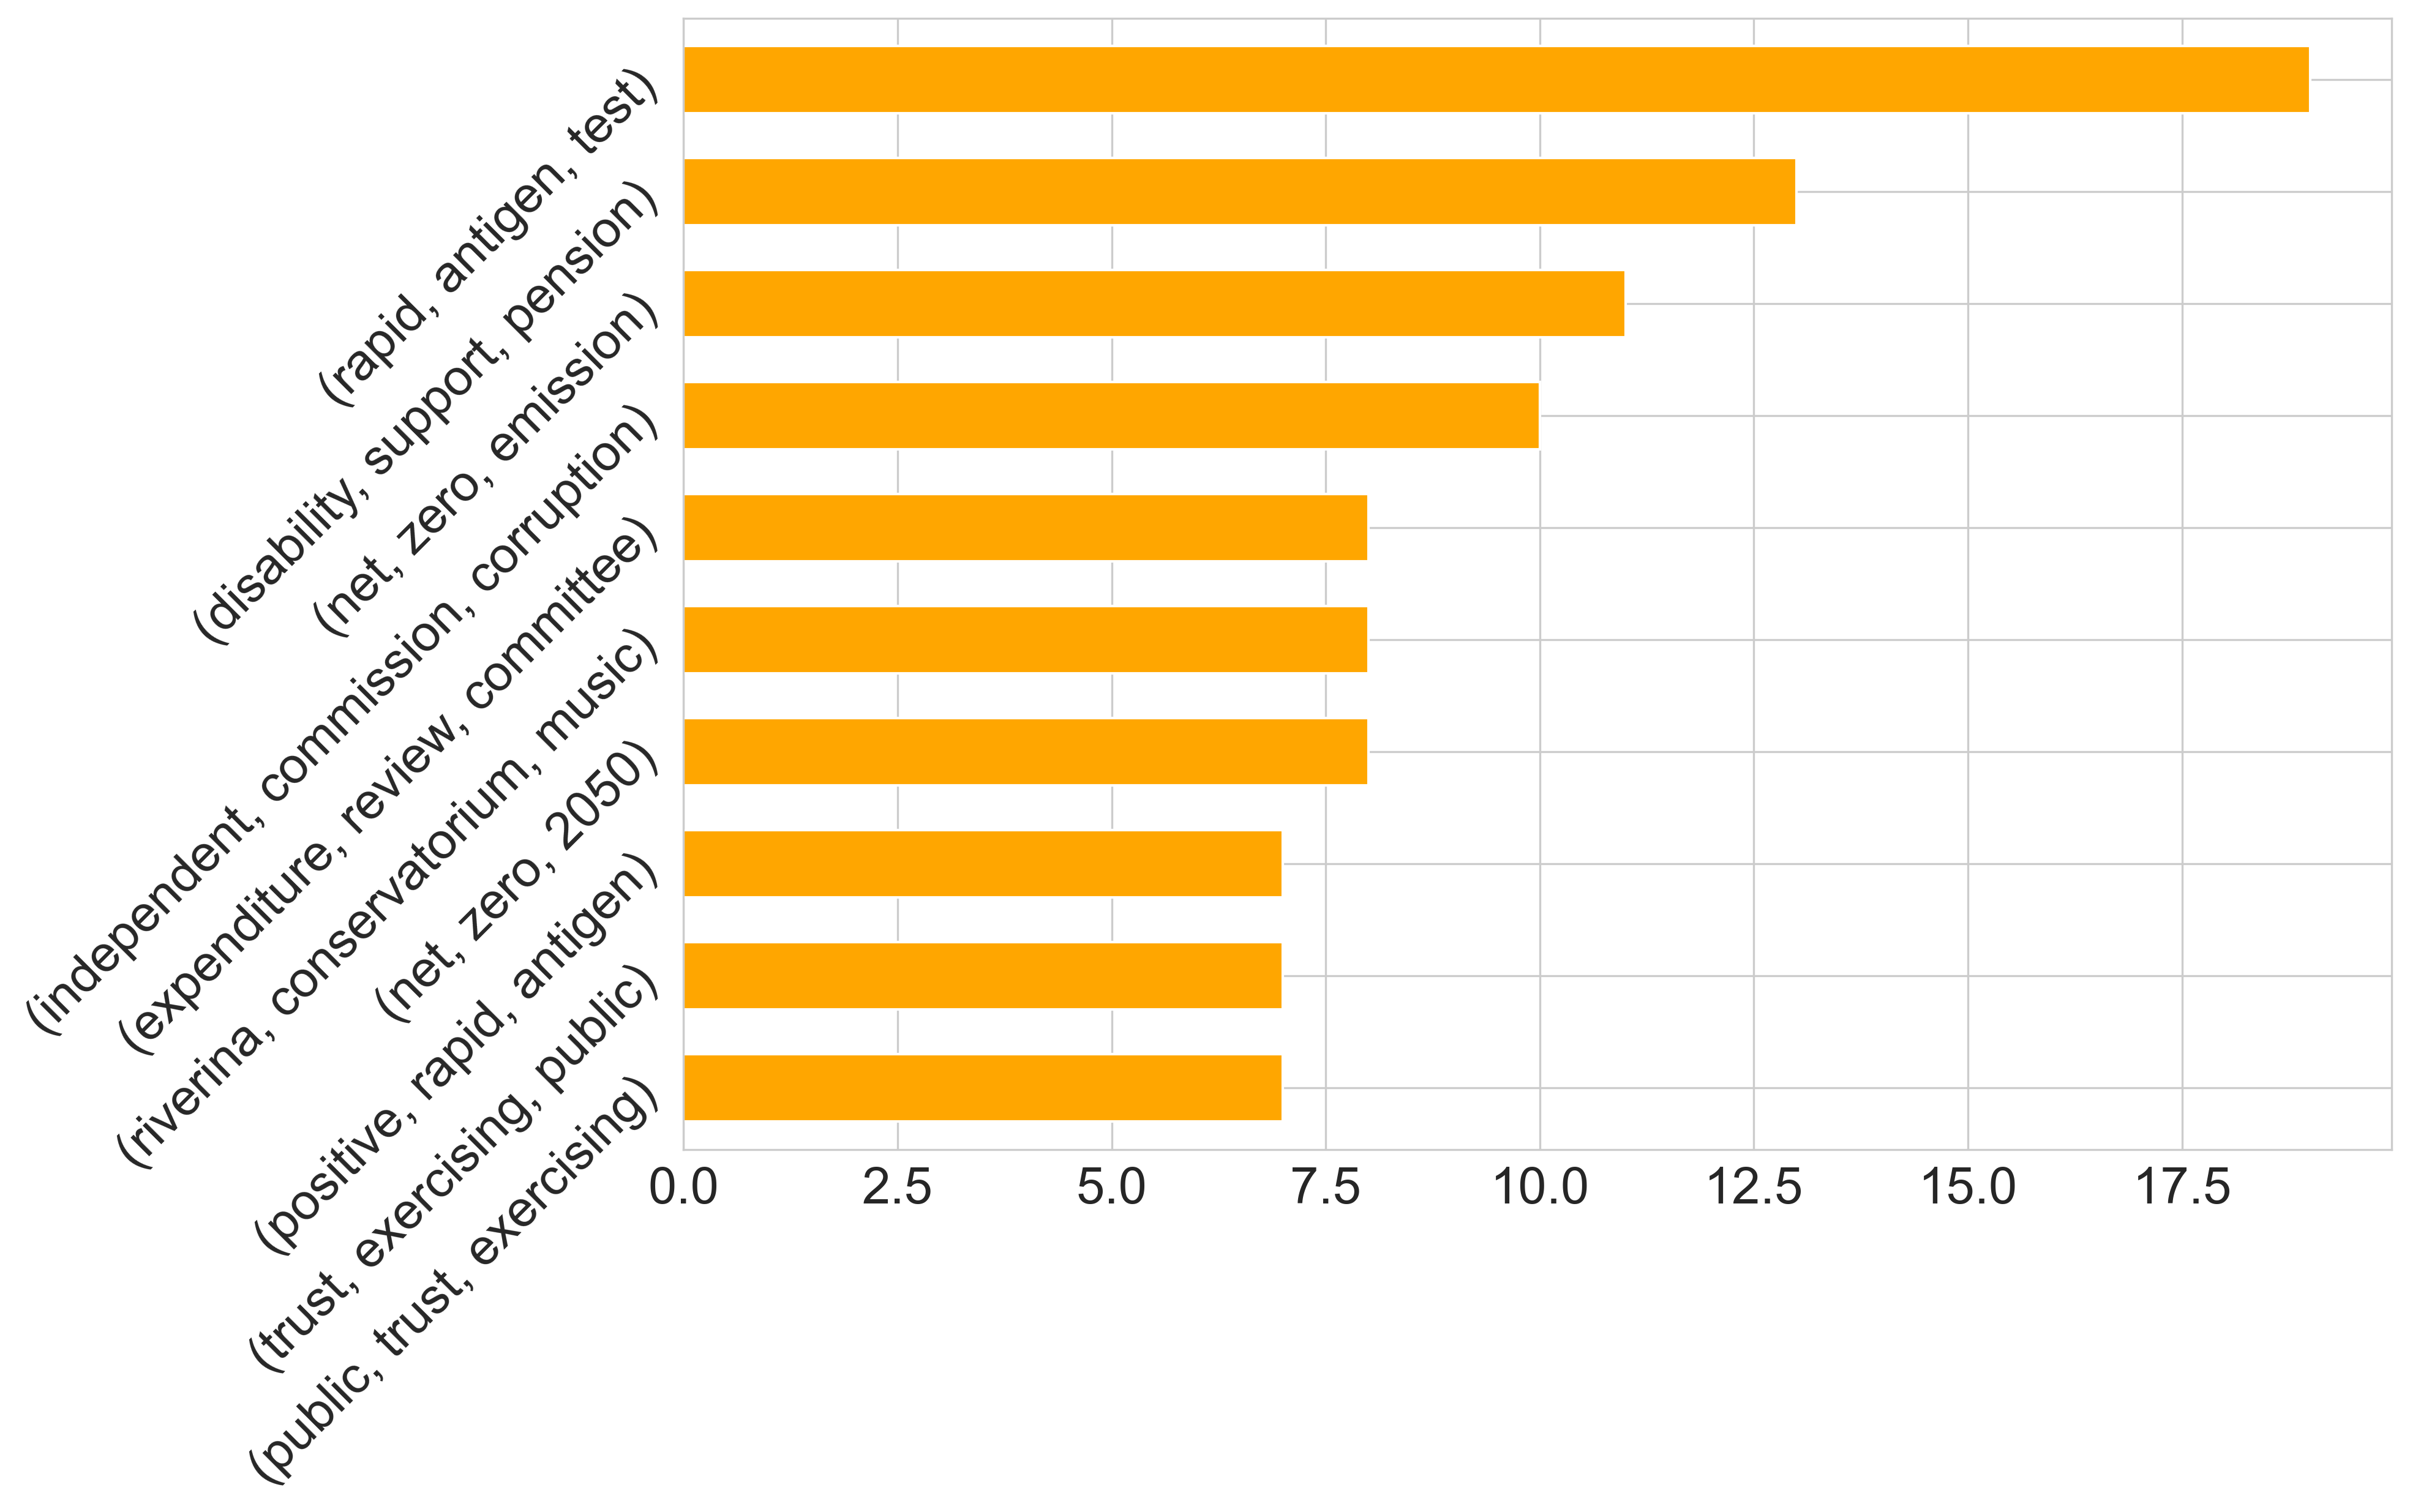

In [ ]:

plot_trigrams3(australia_news_df, '2021-07-01', '2021-9-30', top=10)
plot_trigrams3(australia_news_df, '2021-10-01', '2021-12-31', top=10)

Number of rows in filtered data: 1830


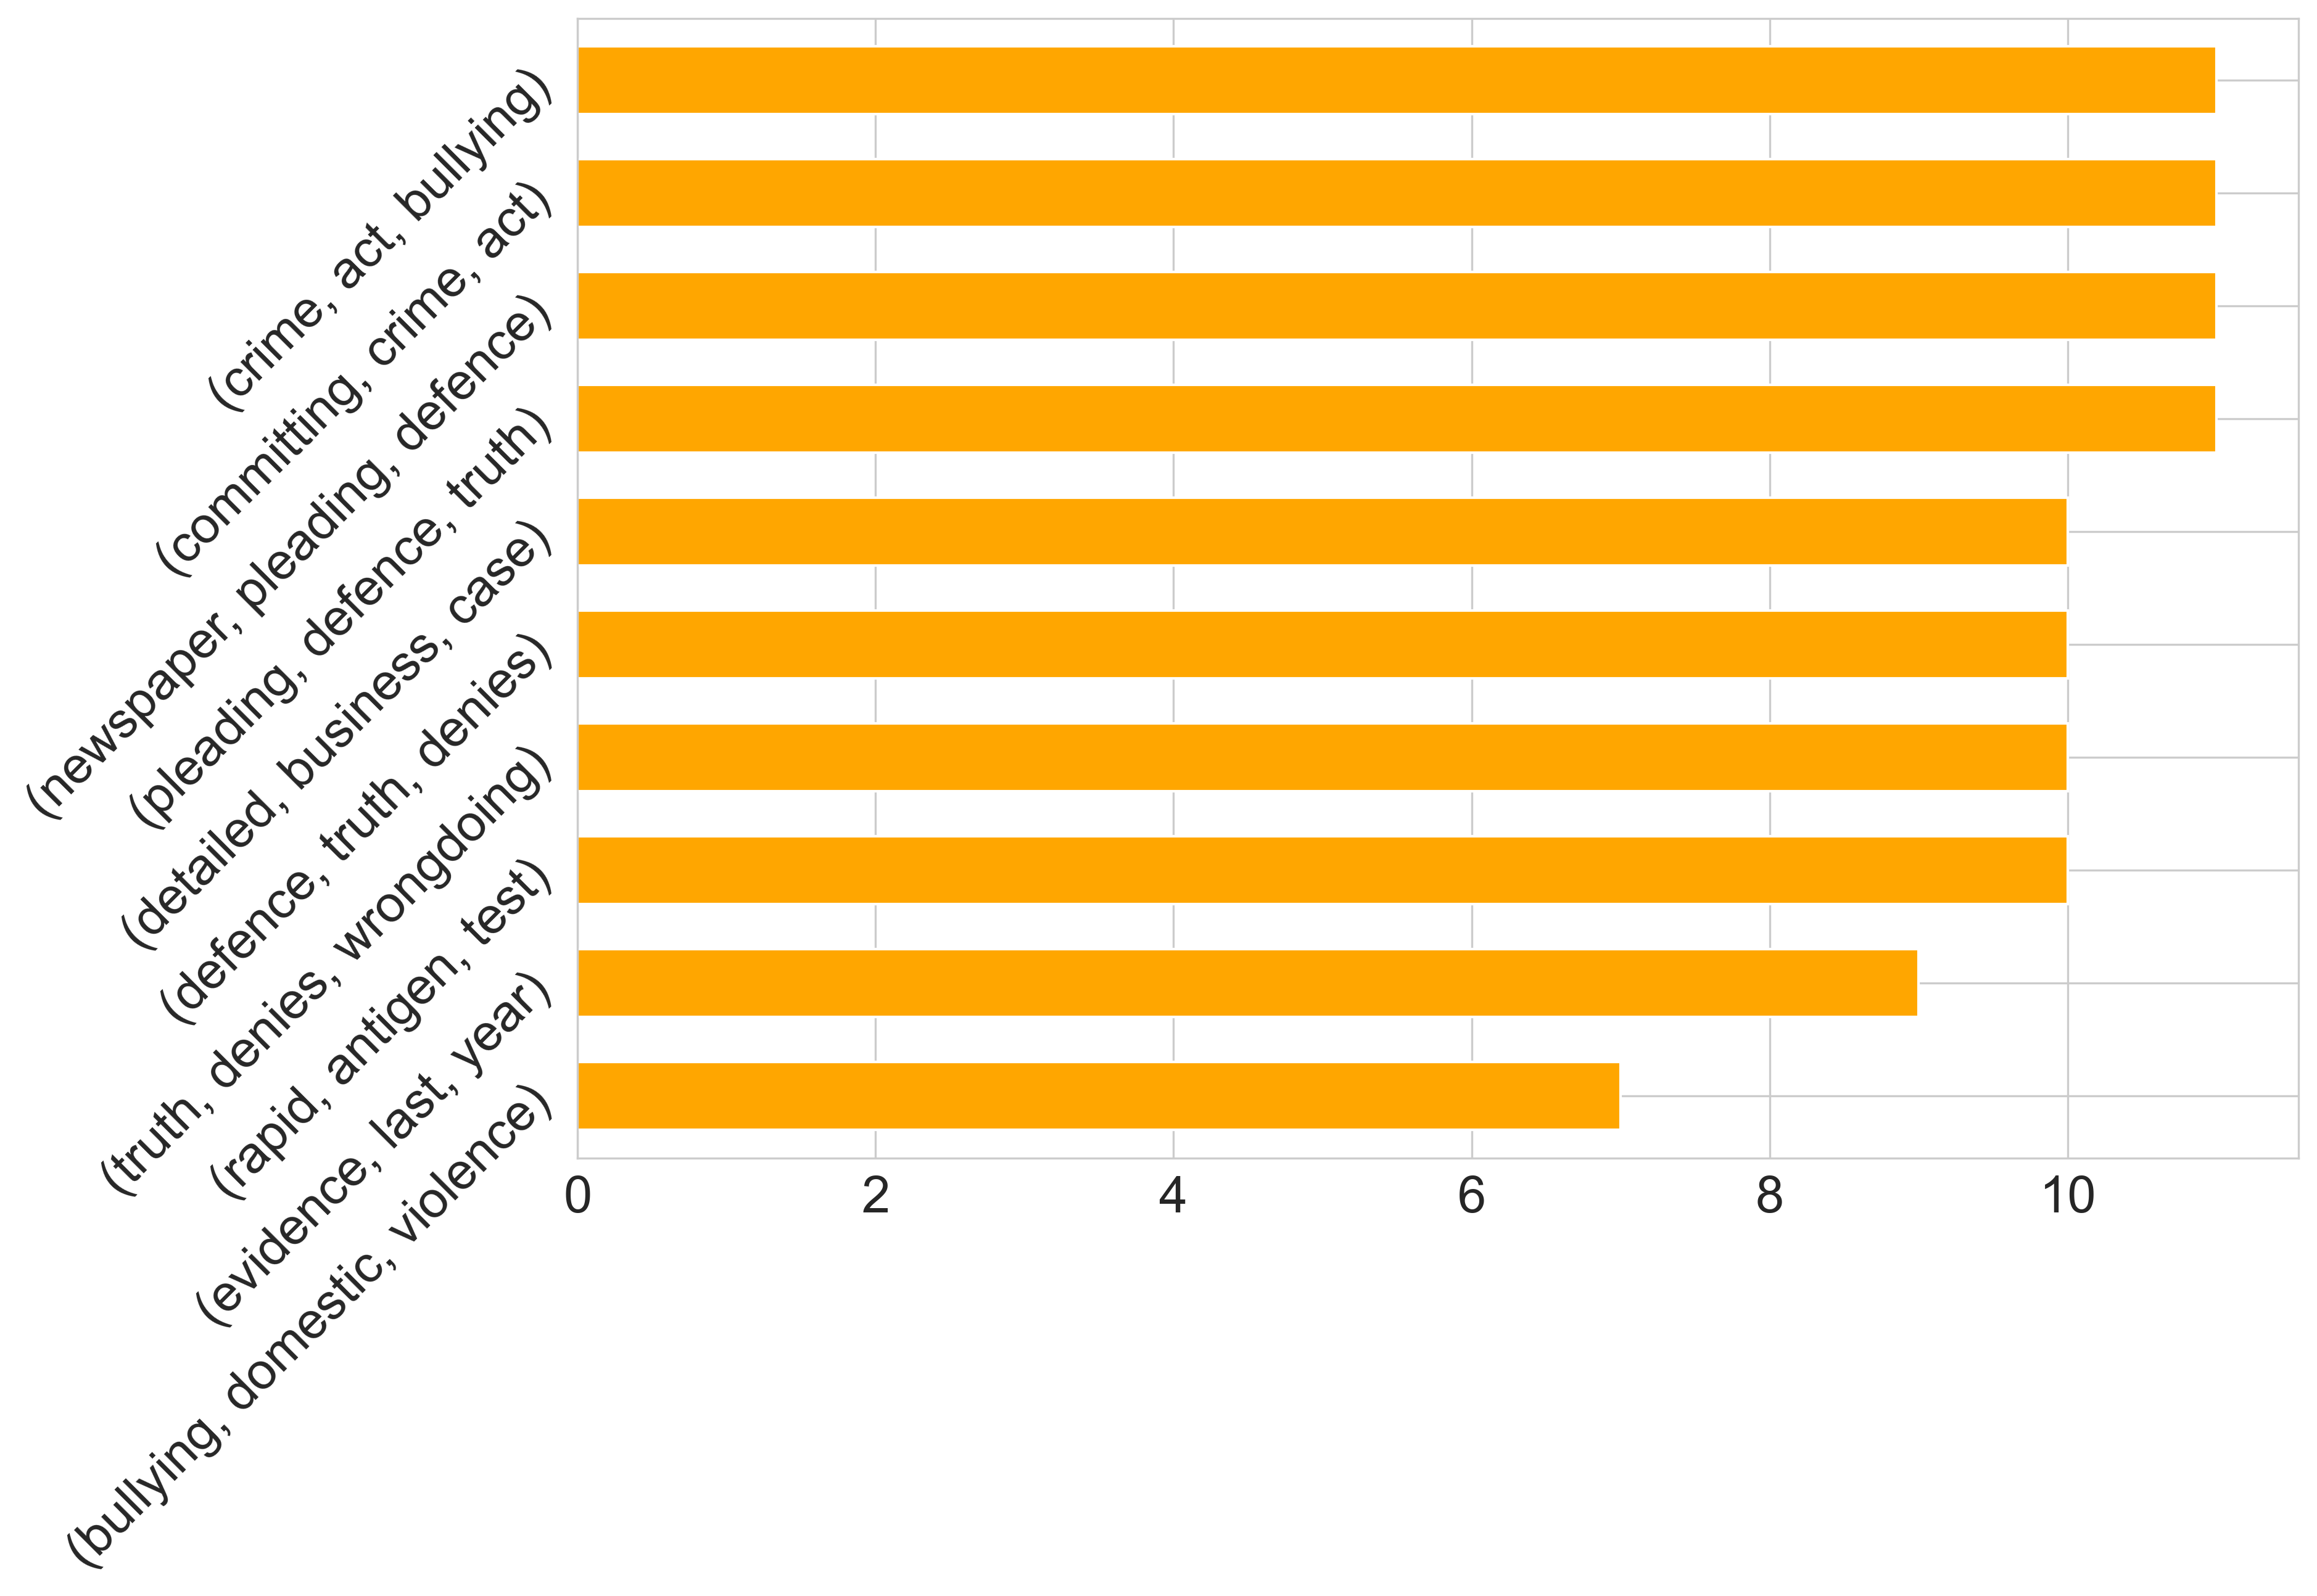

In [ ]:
plot_trigrams3(australia_news_df, '2022-01-01', '2022-3-31', top=10)

In [ ]:
uk_news_df = df.loc[df['sectionName'] == 'UK news']

Number of rows in filtered data: 1946


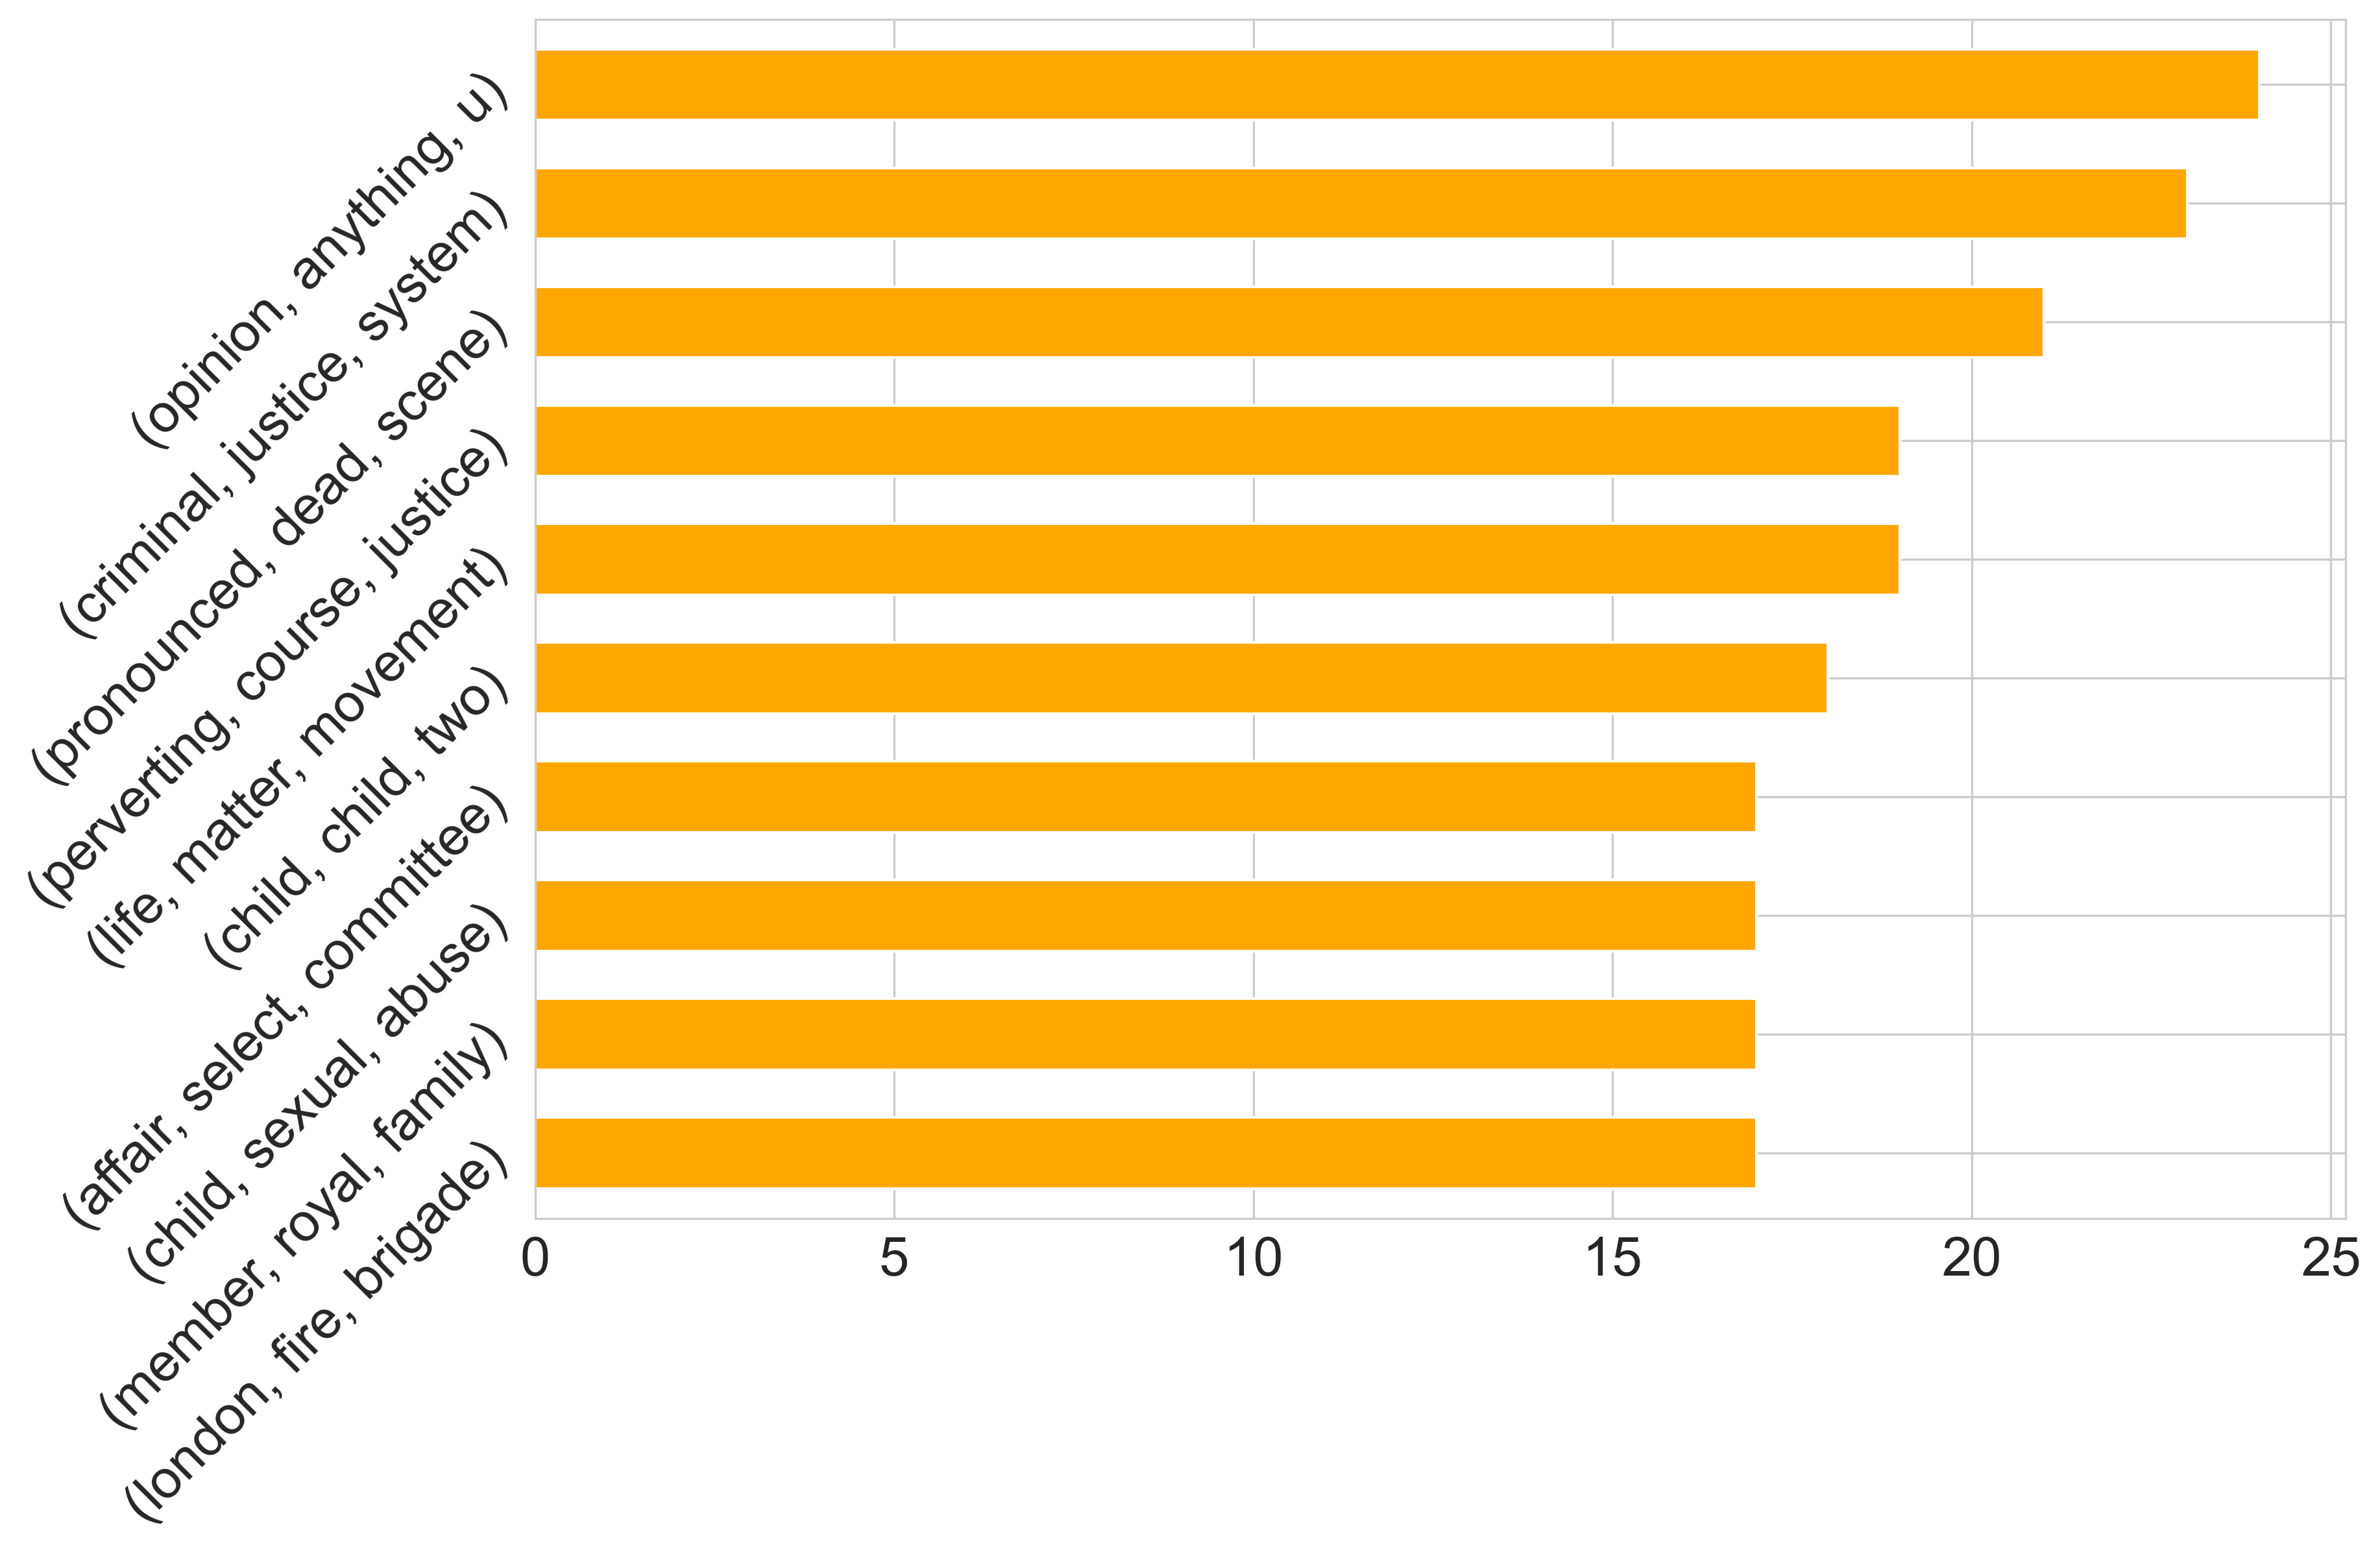

In [ ]:
plot_trigrams3(uk_news_df, '2020-1-1', '2022-3-31', top=10)
#plot_trigrams3(uk_news_df, '2020-4-1', '2020-6-30', top=10)
#plot_trigrams3(uk_news_df, '2020-7-1', '2020-9-30', top=10)

In [ ]:
world_df = df.loc[df['sectionName'] == 'World news']
print(world_df.head())

                                          bodyContent  Optimistic  Thankful  \
1   Twenty-two school children on their way to sta...         0.0       0.0   
24  The soldiers came in the darkness to Majuma Be...         0.0       0.0   
32  Anyone who thinks the business of cannabis cul...         0.0       0.0   
35  A senior opposition leader in Kenya has said u...         0.0       0.0   
46  The prominent Swiss academic Tariq Ramadan, a ...         0.0       0.0   

    Empathetic  Pessimistic  Anxious  Sad  Annoyed  Denial  Official report  \
1          0.0          0.0      0.0  1.0      0.0     0.0              1.0   
24         0.0          0.0      1.0  1.0      0.0     0.0              0.0   
32         0.0          0.0      0.0  1.0      0.0     0.0              0.0   
35         0.0          0.0      0.0  0.0      0.0     0.0              1.0   
46         0.0          0.0      0.0  0.0      0.0     0.0              1.0   

    Joking sectionName webPublicationDate year_qua

In [ ]:
def plot_trigrams4(data, start_date, end_date, top, color='#ffa600'):
    # Filter rows where any specified emotional state is 1
    filtered_data = data[(data['Annoyed'] == 1)|(data['Denial'] == 1)|(data['Sad'] == 1)|(data['Anxious'] == 1)]
    print("Number of rows in filtered data:", len(filtered_data))
    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(filtered_data, start_date, end_date)

    # Clean and concatenate tweet data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['bodyContent']))

    # Calculate trigrams
    trigrams_series = pd.Series(nltk.ngrams(cleaned_data, 3)).value_counts()[:top]

    # Plot trigrams
    plt.figure(figsize=(12, 8),dpi=300)
    trigrams_series.sort_values().plot.barh(color=color, width=0.6)
    plt.xticks(fontsize=20)
    plt.yticks(rotation=45, fontsize=20)# Enlarged font size for y-axis labels
    #plt.tight_layout(pad=3.0)
    plt.show()

Number of rows in filtered data: 5327


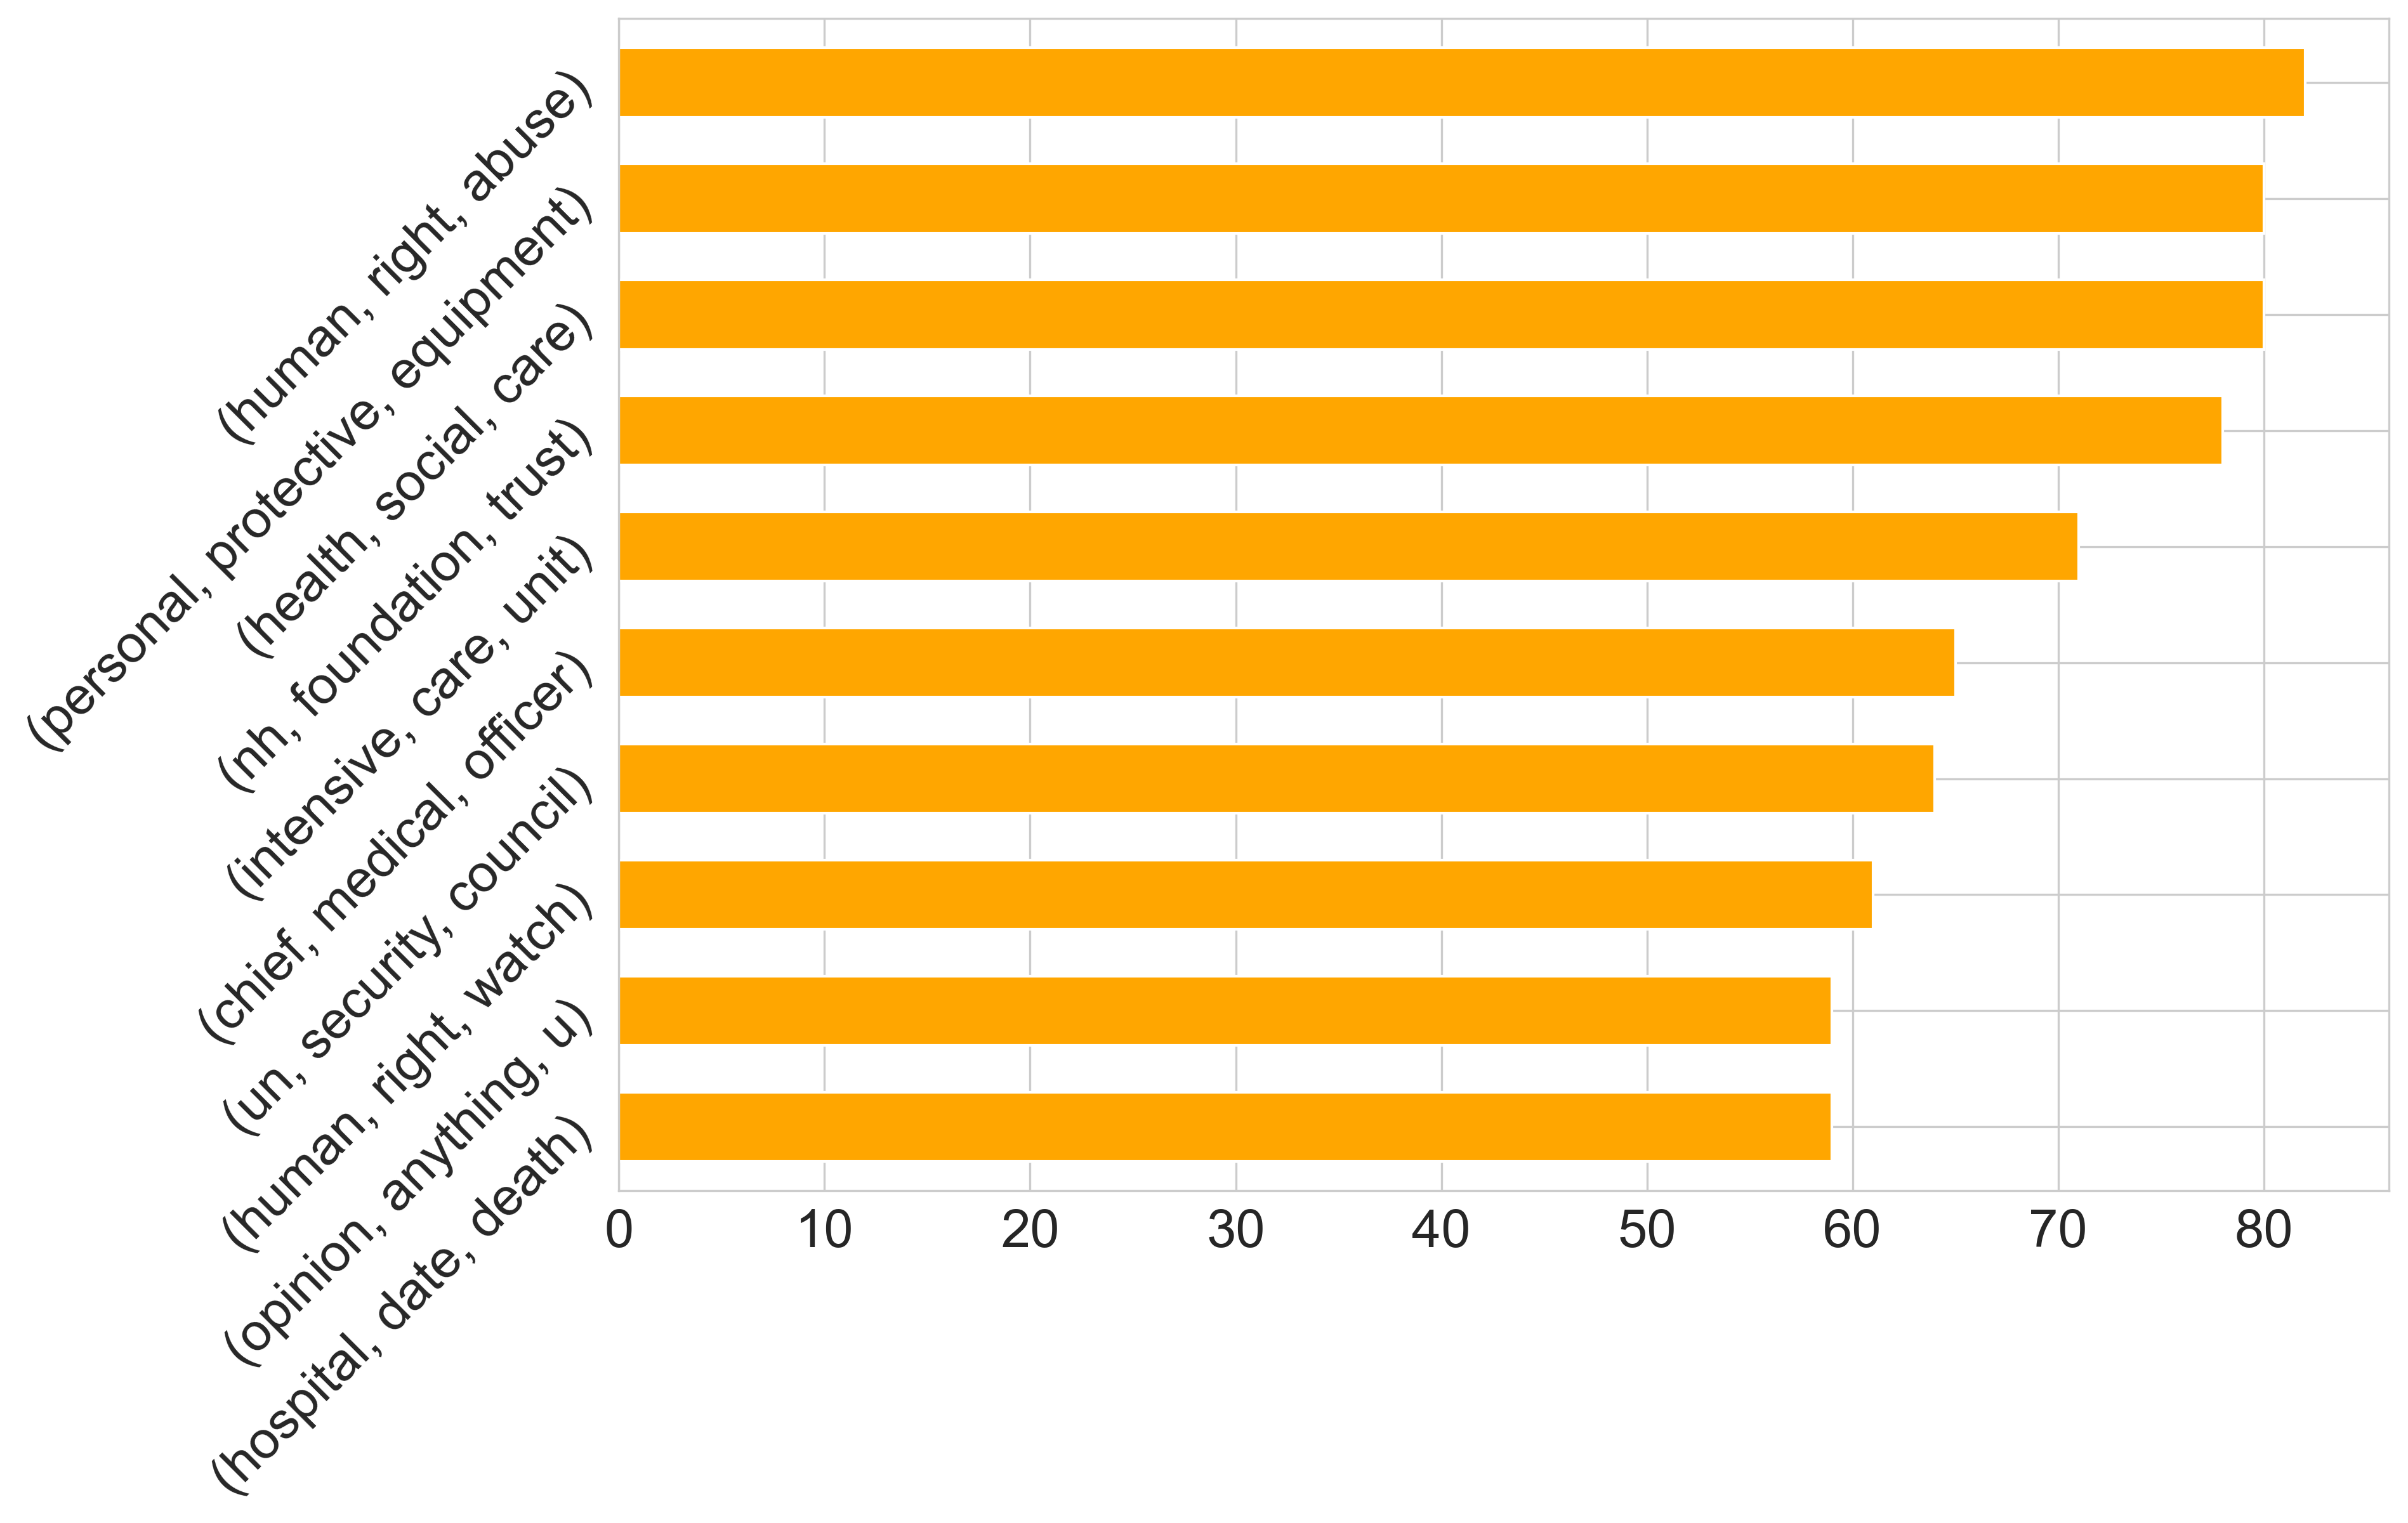

In [ ]:
plot_trigrams4(world_df, '2020-01-01', '2022-03-31', top=10)

In [ ]:
def clean1(text):
    wnl = nltk.stem.WordNetLemmatizer()

    stop_words = set(stopwords.words('english'))


    extra_stop_words = ['ali', 'article', 'bad', 'belt', 'berkeley', 'black', 'bush', 'came', 'can', 'click','chancellor', 'china',  'com', 'come', 'comes', 'coming', 'considered', 'court', 'department', 'dutton', 'daryl', 'eve', 'email', 'every', 'four','federal', 'george', 'go', 'going', 'good',  'green', 'guardian','letter','letters', 'industry', 'including', 'important', 'isle', 'islander', 'just', 'kensington', 'know', 'known', 'ltd', 'like', 'look', 'looking', 'looks', 'labor', 'mohammed', 'made', 'make', 'makes', 'malik', 'many', 'may', 'meal', 'matt', 'might', 'months', 'morning', 'national', 'need', 'needed', 'number', 'numbers', 'observer', 'office', 'one','publish', 'places', 'place', 'please', 'point','priti','patel', 'pty', 'points', 'police', 'president', 'prime', 'prosecution', 'papua', 'pompeo', 'paulo', 'rapporteur', 'received','radio', 'read', 'receive', 'report', 'said', 'says', 'scott','story','stories', 'school', 'secretary', 'seeing', 'seen', 'sign', 'state', 'story', 'street', 'strait', 'supreme', 'take', 'takes', 'tell', 'tells', 'think', 'thinks', 'thought', 'time', 'times', 'today', 'top', 'told', 'torres', 'university', 'upload','use', 'used', 'using', 'wales', 'want', 'wants', 'way', 'ways', 'week', 'work', 'worked', 'world', 'wagga', 'you', 'york', 'young', 'zealand','grey','hunt','josh','deniel','north','aged','western','robertssmith','well','murder','war','anthony','alex','besanko','youve','mustreads','inbox','mail','would','roy','mp','berejiklian','youd','guardianletterstheguardiancom','gucomletters','join', 'debate', 'visit', 'bright', 'early', 'already', 'best','submission','submissions','photo', 'share', 'reader','print','weekday','recep','tayyip','erdogan','inboxes','aung','san','suu','receiving','delivered','marine']

    stop_words.update(extra_stop_words)

    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()

    # 对于带撇号的单词，去掉撇号后再判断是否在停用词表中
    words = [word if "'" not in word else word.split("'")[0] for word in words]
    words = [word for word in words if len(word) > 1]
    return [wnl.lemmatize(word) for word in words if word not in stop_words]

In [ ]:
def plot_trigrams5(data, start_date, end_date, top, color='#ffa600'):
    # Filter rows where any specified emotional state is 1
    filtered_data = data[(data['Annoyed'] == 1)|(data['Denial'] == 1)|(data['Sad'] == 1)|(data['Anxious'] == 1)]
    print("Number of rows in filtered data:", len(filtered_data))
    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(filtered_data, start_date, end_date)

    # Clean and concatenate tweet data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean1(''.join(quarterly_data['bodyContent']))

    # Calculate trigrams
    trigrams_series = pd.Series(nltk.ngrams(cleaned_data, 3)).value_counts()[:top]

    # Plot trigrams
    plt.figure(figsize=(12, 8),dpi=300)
    trigrams_series.sort_values().plot.barh(color=color, width=0.6)
    plt.xticks(fontsize=20)
    plt.yticks(rotation=45, fontsize=20)#  Enlarged font size for y-axis labels
    #plt.tight_layout(pad=3.0)
    plt.show()

Number of rows in filtered data: 5327


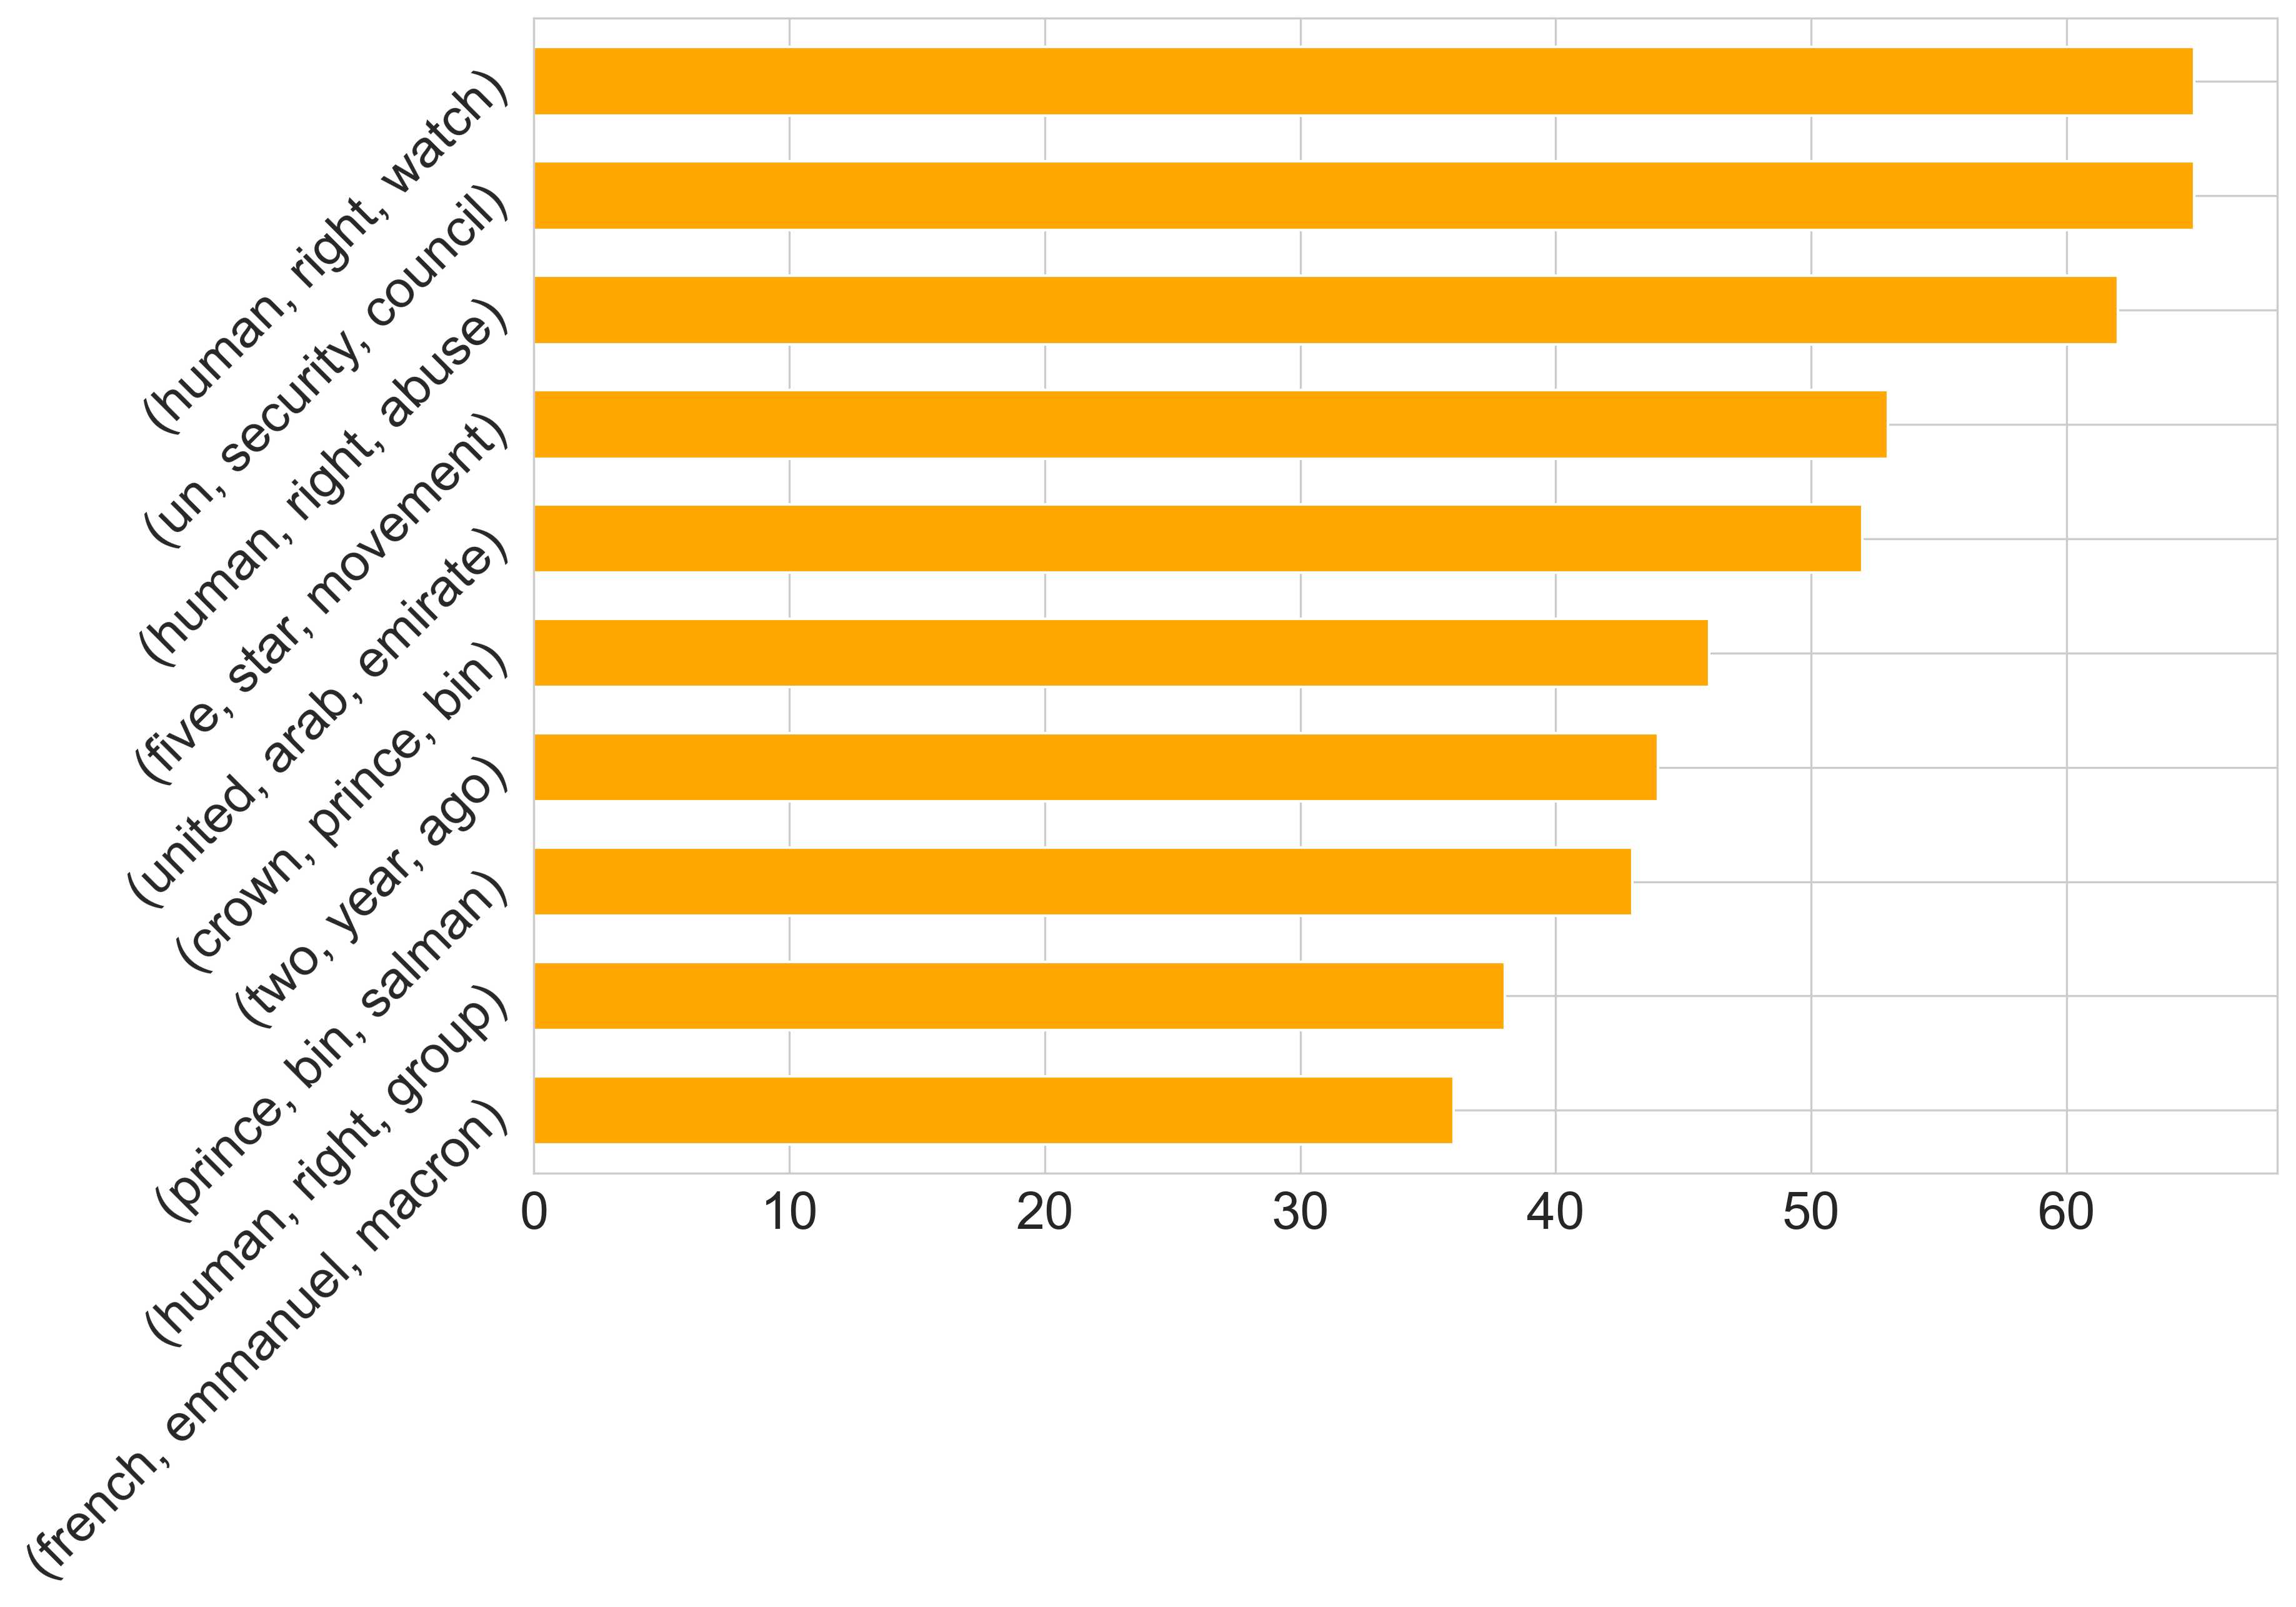

In [ ]:
plot_trigrams5(world_df,'2018-1-1','2019-12-31',top=10)

In [ ]:
def filter_and_save_data(df, start_date, end_date, section_names, output_file_path):
    """
    Filter data based on specified date range and partial name, and save to specified path.

    Args:
    - df: DataFrame
    - start_date: start 'YYYY-MM-DD'
    - end_date: end 'YYYY-MM-DD'
    - section_name:
    - output_file_path:
    """
    # Convert date column to datetime format
    df['webPublicationDate'] = pd.to_datetime(df['webPublicationDate'])

    # Filter data
    filtered_df = df[(df['webPublicationDate'] >= start_date) & (df['webPublicationDate'] <= end_date) & (df['sectionName'].isin(section_names))]

    # Remove rows with missing content
    filtered_df = filtered_df.dropna(subset=['bodyContent'])

    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

    # save data
    filtered_df.to_csv(output_file_path, index=False)

    print("Filtered data has been saved to:", output_file_path)

In [ ]:
start_date = '2018-01-01'
end_date = '2022-12-31'

# save world news
world_news_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\world_news_articles_2018_to_2022.csv"
wsection_names = ['World news']
filter_and_save_data(df, start_date, end_date, wsection_names, world_news_output_file_path)

# save Australia news
au_news_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\australia_news_articles_2018_to_2022.csv"
ausection_names = ['Australia news']
filter_and_save_data(df, start_date, end_date, ausection_names, au_news_output_file_path)

# save UK news
uk_news_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\uk_articles_2018_to_2022.csv"
ukn_names = ['UK news']
filter_and_save_data(df, start_date, end_date, ukn_names, uk_news_output_file_path)

# save opinion articles
opinion_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\opinion_articles_2018_to_2022.csv"
opinion_names = ['Opinion']
filter_and_save_data(df, start_date, end_date, opinion_names, opinion_output_file_path)

Filtered data has been saved to: D:\UNSW\2024T1\MATH5925\data\world_news_articles_2018_to_2022.csv
Filtered data has been saved to: D:\UNSW\2024T1\MATH5925\data\australia_news_articles_2018_to_2022.csv
Filtered data has been saved to: D:\UNSW\2024T1\MATH5925\data\uk_articles_2018_to_2022.csv
Filtered data has been saved to: D:\UNSW\2024T1\MATH5925\data\opinion_articles_2018_to_2022.csv


In [ ]:
world_news_df = pd.read_csv(r"D:\UNSW\2024T1\MATH5925\data\world_news_articles_2018_to_2022.csv")
au_news_df = pd.read_csv(r"D:\UNSW\2024T1\MATH5925\data\australia_news_articles_2018_to_2022.csv")
uk_news_df = pd.read_csv(r"D:\UNSW\2024T1\MATH5925\data\uk_articles_2018_to_2022.csv")
opinion_df = pd.read_csv(r"D:\UNSW\2024T1\MATH5925\data\opinion_articles_2018_to_2022.csv")

In [ ]:
world_news_df['webPublicationDate'] = pd.to_datetime(world_news_df['webPublicationDate'])
au_news_df['webPublicationDate'] = pd.to_datetime(au_news_df['webPublicationDate'])
uk_news_df['webPublicationDate'] = pd.to_datetime(uk_news_df['webPublicationDate'])
opinion_df['webPublicationDate'] = pd.to_datetime(opinion_df['webPublicationDate'])
df['webPublicationDate'] = pd.to_datetime(df['webPublicationDate'])

world_news_df['Year'] = world_news_df['webPublicationDate'].dt.year
au_news_df['Year'] = au_news_df['webPublicationDate'].dt.year
uk_news_df['Year'] = uk_news_df['webPublicationDate'].dt.year
opinion_df['Year'] = opinion_df['webPublicationDate'].dt.year
df['Year'] = df['webPublicationDate'].dt.year

world_news_2019 = world_news_df[world_news_df['Year'] == 2019]

au_news_2019 = au_news_df[au_news_df['Year'] == 2019]

uk_news_2019 = uk_news_df[uk_news_df['Year'] == 2019]

In [ ]:
def plot_ngrams_for_dataset(data, dataset_name, start_date, end_date, n=[2], top=15, colors=('#00429d', '#ffa600')):
    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(data, start_date, end_date)

    # Clean the data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['bodyContent']))

    plt.figure(figsize=(15, 16))

    # 对于每个n，创建一个子图
    for i, n_val in enumerate(n):
        # 创建子图；调整子图间的垂直间距
        ax = plt.subplot(len(n), 1, i+1)

        # 计算n-grams并绘制条形图
        ngrams_series = pd.Series(nltk.ngrams(cleaned_data, n_val)).value_counts()[:top]
        ngrams_series.sort_values().plot.barh(color=colors[i % len(colors)], width=0.5, ax=ax)

        # Set tick parameters without titles
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=20, rotation=45)

    # 调整子图布局
    plt.tight_layout(pad=3.0)
    plt.show()

plot_ngrams_for_dataset(world_news_df, 'World News 2020', '2020-01-01', '2020-03-31', n=[2, 3], top=10, colors=('#00429d', '#ffa600'))

In [ ]:
def plot_ngrams_for_dataset1(data, dataset_name, start_date, end_date, n=[2], top=15, colors=('#00429d', '#ffa600')):
    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(data, start_date, end_date)

    # Clean the data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['bodyContent']))

    # 对于每个n，创建一个单独的图形对象并设置子图
    for i, n_val in enumerate(n):
        plt.figure(figsize=(15, 8))  # 创建一个新的图形对象
        ax = plt.subplot()  # 设置子图

        # 计算n-grams并绘制条形图
        ngrams_series = pd.Series(nltk.ngrams(cleaned_data, n_val)).value_counts()[:top]
        ngrams_series.sort_values().plot.barh(color=colors[i % len(colors)], width=0.5, ax=ax)

        # 设置子图的标题
        #ax.set_title(f'Top {top} {n_val}-grams in {dataset_name} ({start_date} to {end_date})', fontsize=16)

        # 设置tick参数
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=22, rotation=45)

        plt.show()  # 显示当前图形对象


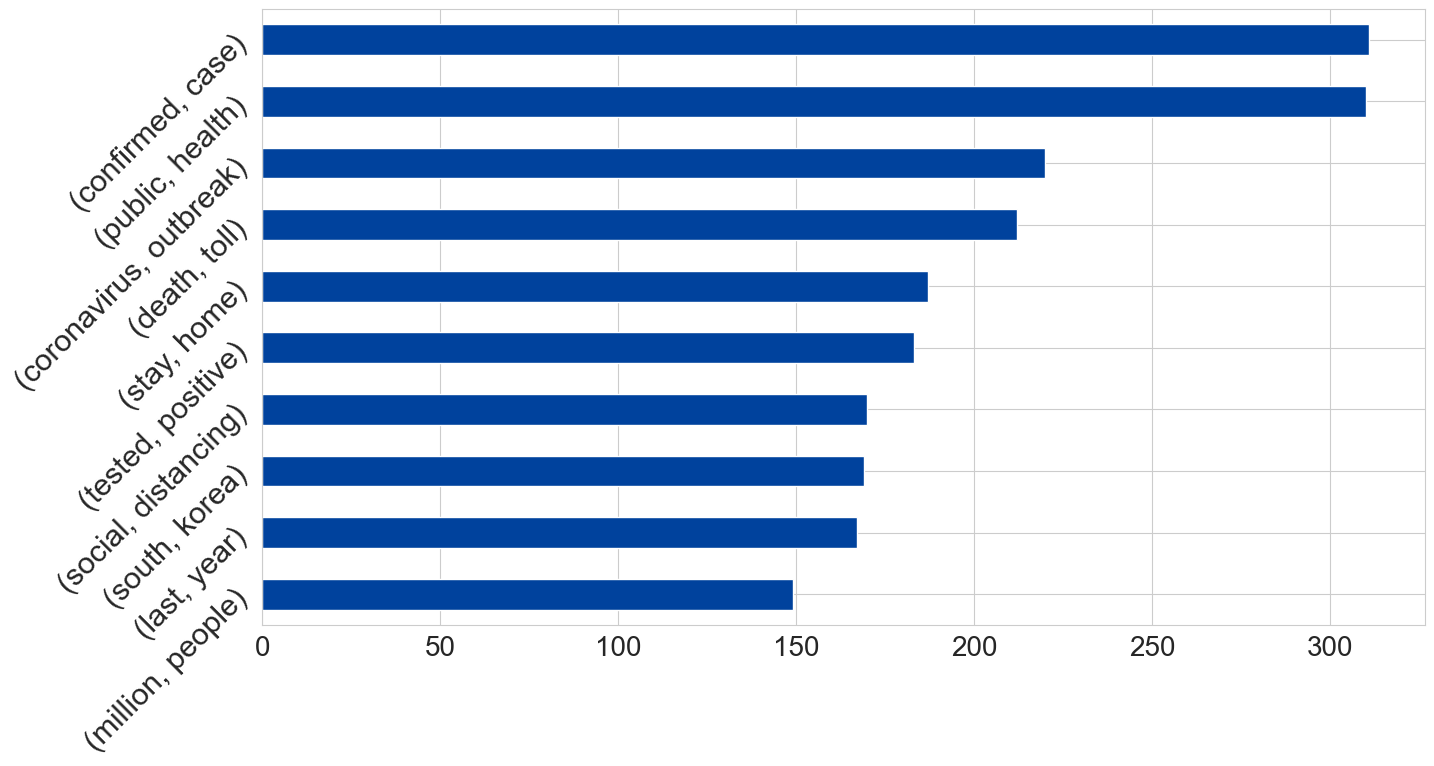

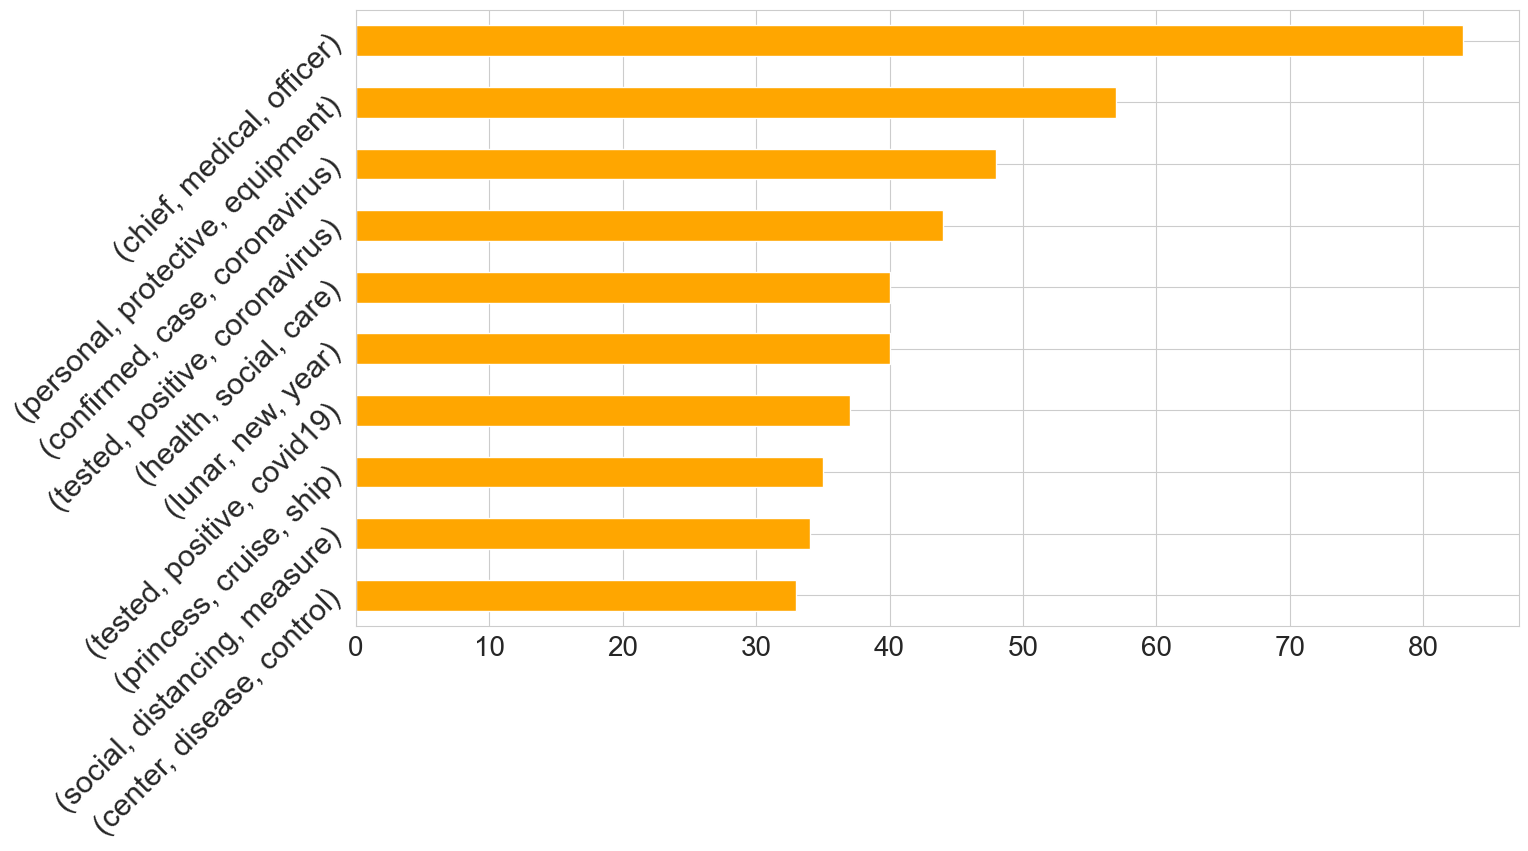

In [ ]:
plot_ngrams_for_dataset1(world_news_df, 'World News 2020', '2020-01-01', '2020-03-31', n=[2, 3], top=10, colors=('#00429d', '#ffa600'))

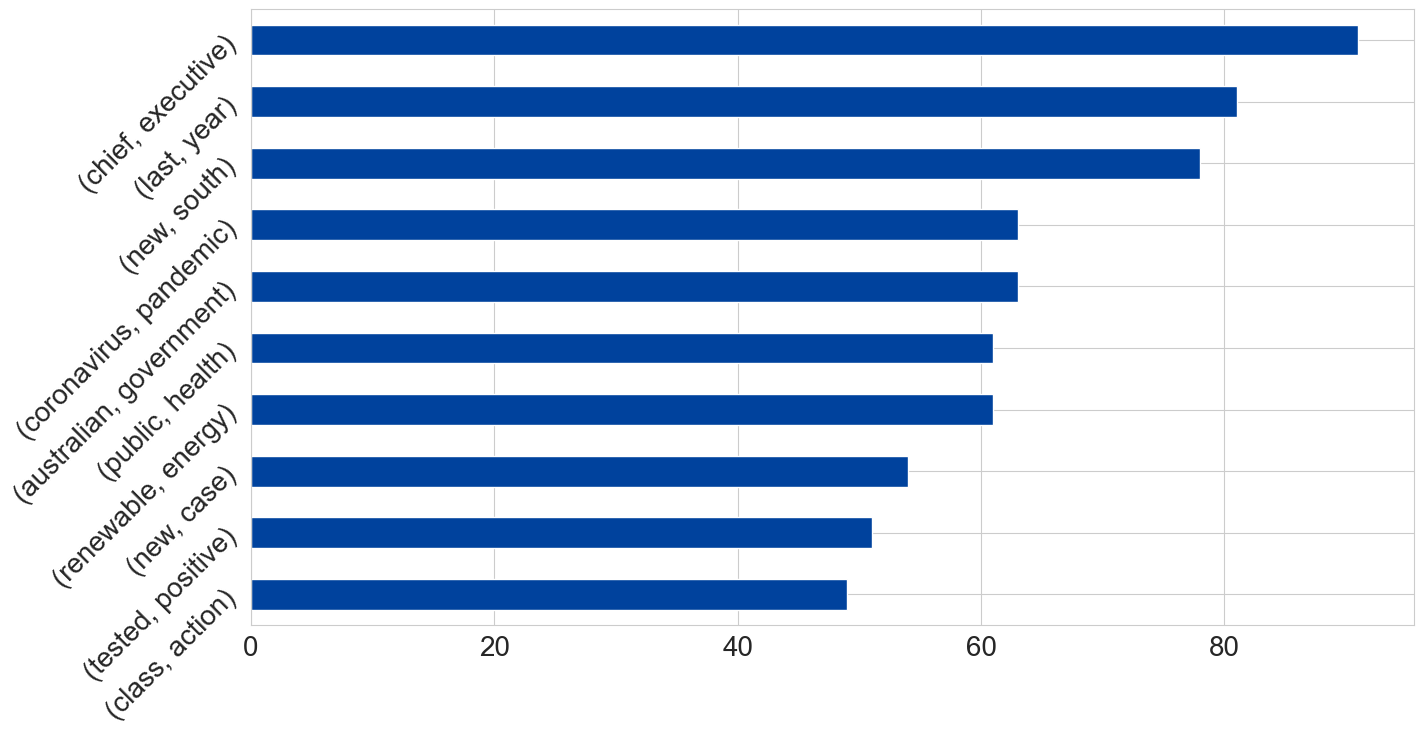

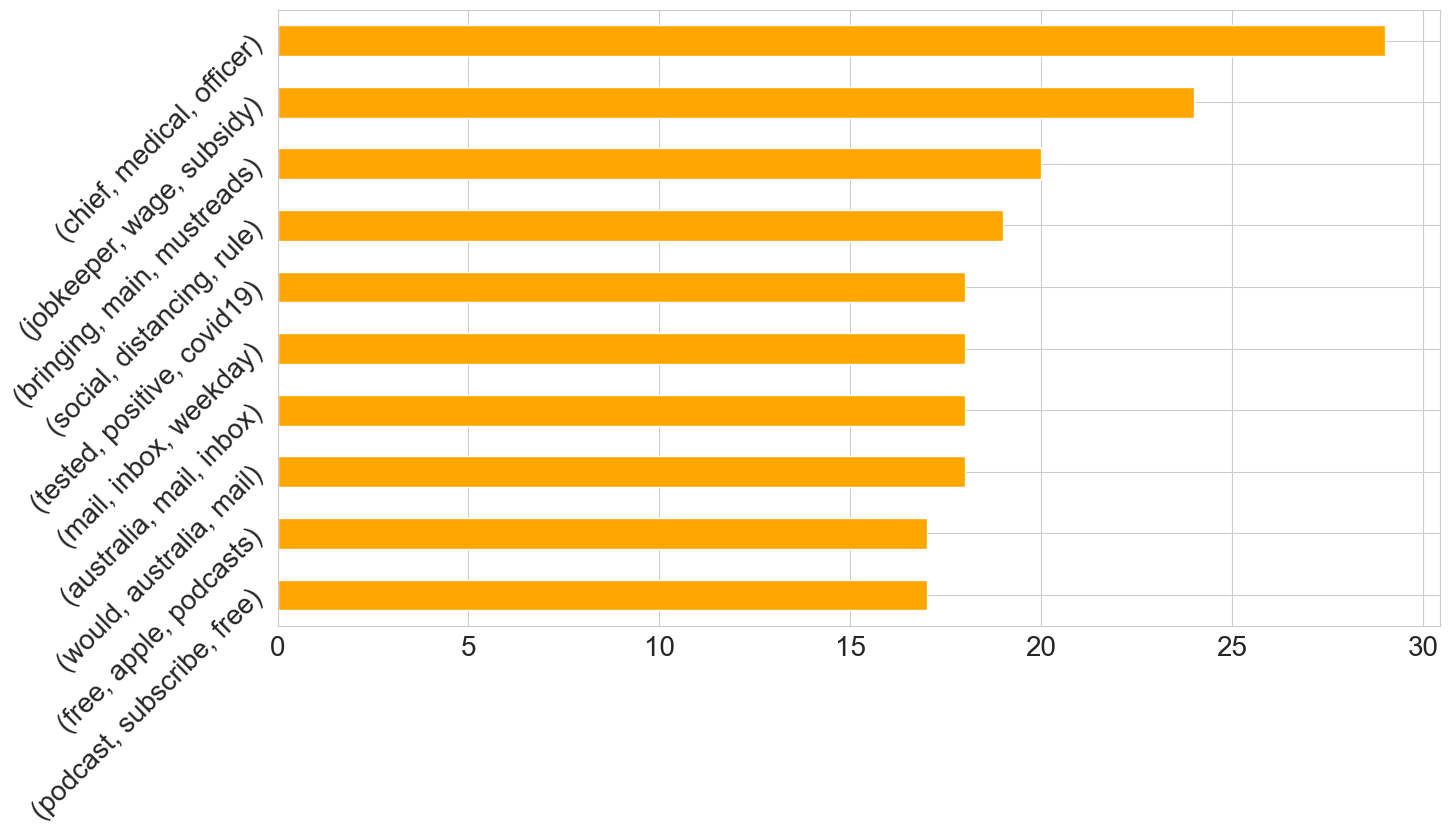

In [ ]:
plot_ngrams_for_dataset1(au_news_df, 'Australia News 2020 Q2', '2020-04-01', '2020-06-30', n=[2, 3], top=10, colors=('#00429d', '#ffa600'))

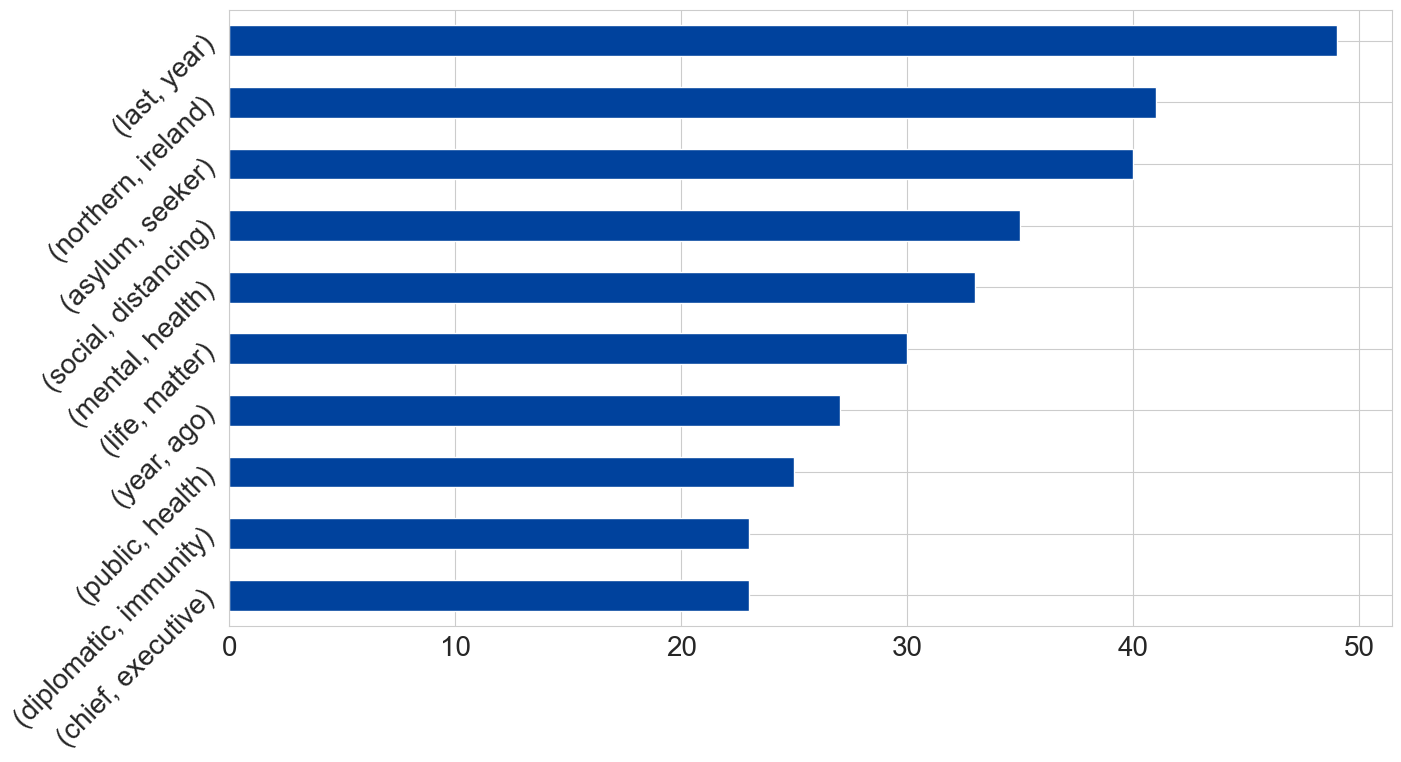

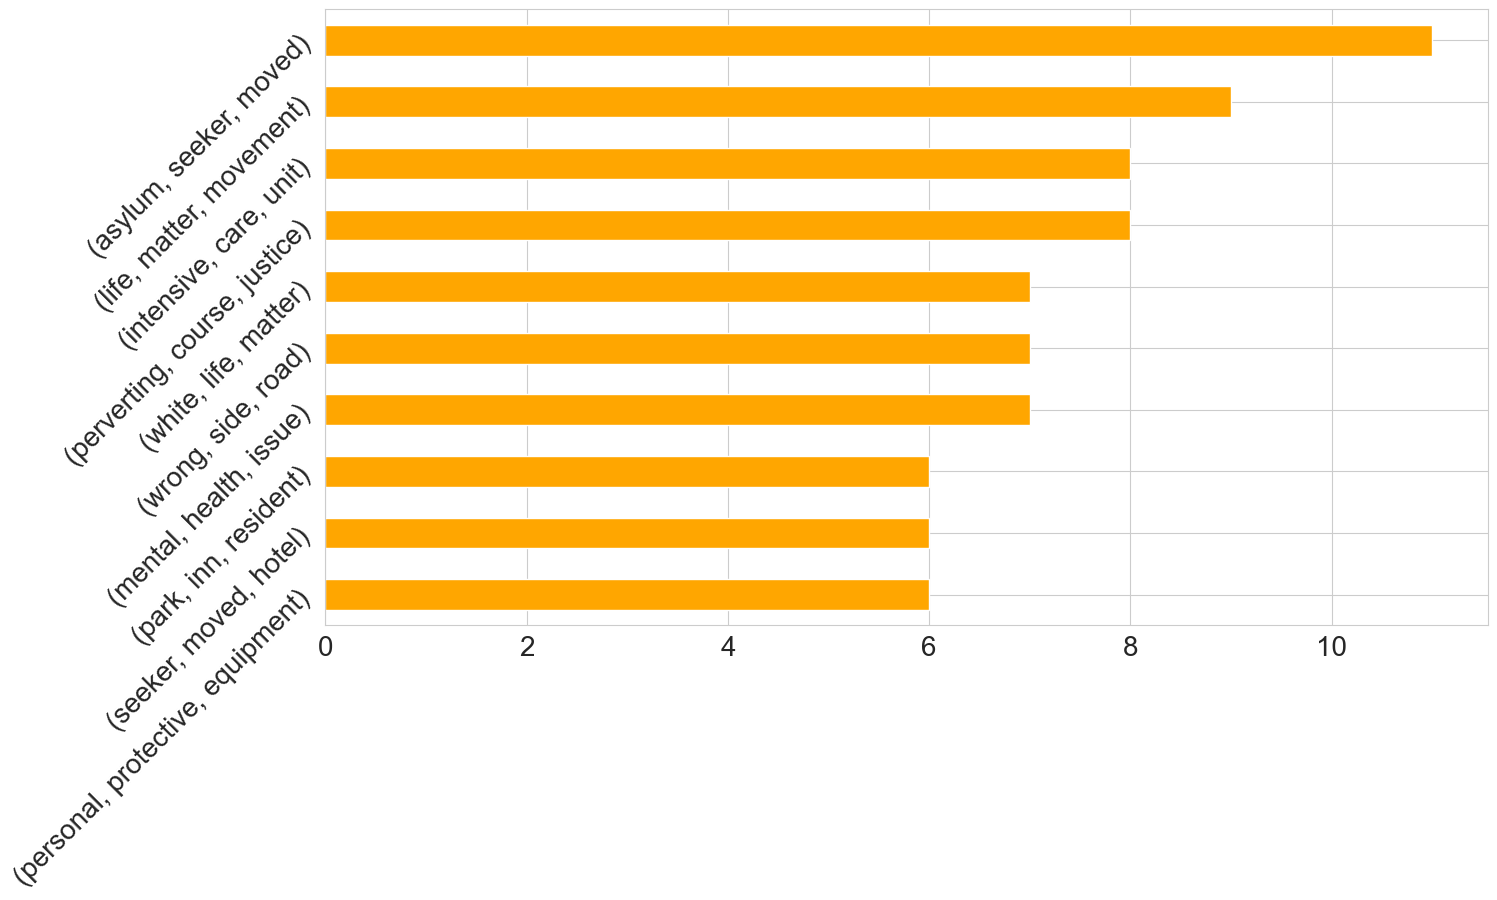

In [ ]:
plot_ngrams_for_dataset1(uk_news_df, 'UK News 2020 Q2', '2020-04-01', '2020-06-30', n=[2, 3], top=10, colors=('#00429d', '#ffa600'))

In [ ]:
def plot_trigrams(data, dataset_name, start_date, end_date, top=15, color='#ffa600'):
    # Filter rows where any specified emotional state is 1
    filtered_data = data[(data['Denial'] == 1) | (data['Annoyed'] == 1) | (data['Anxious'] == 1) | (data['Sad'] == 1)]

    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(filtered_data, start_date, end_date)

    # Clean and concatenate tweet data
    quarterly_data['bodyContent'] = quarterly_data['bodyContent'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['bodyContent']))

    # Calculate trigrams
    trigrams_series = pd.Series(nltk.ngrams(cleaned_data, 3)).value_counts()[:top]

    # Plot trigrams
    plt.figure(figsize=(16, 9))
    trigrams_series.sort_values().plot.barh(color=color, width=0.5)
    plt.xticks(fontsize=20)
    plt.yticks(rotation=45,fontsize=20)  # Enlarged font size for y-axis labels
    #plt.tight_layout(pad=3.0)
    plt.show()

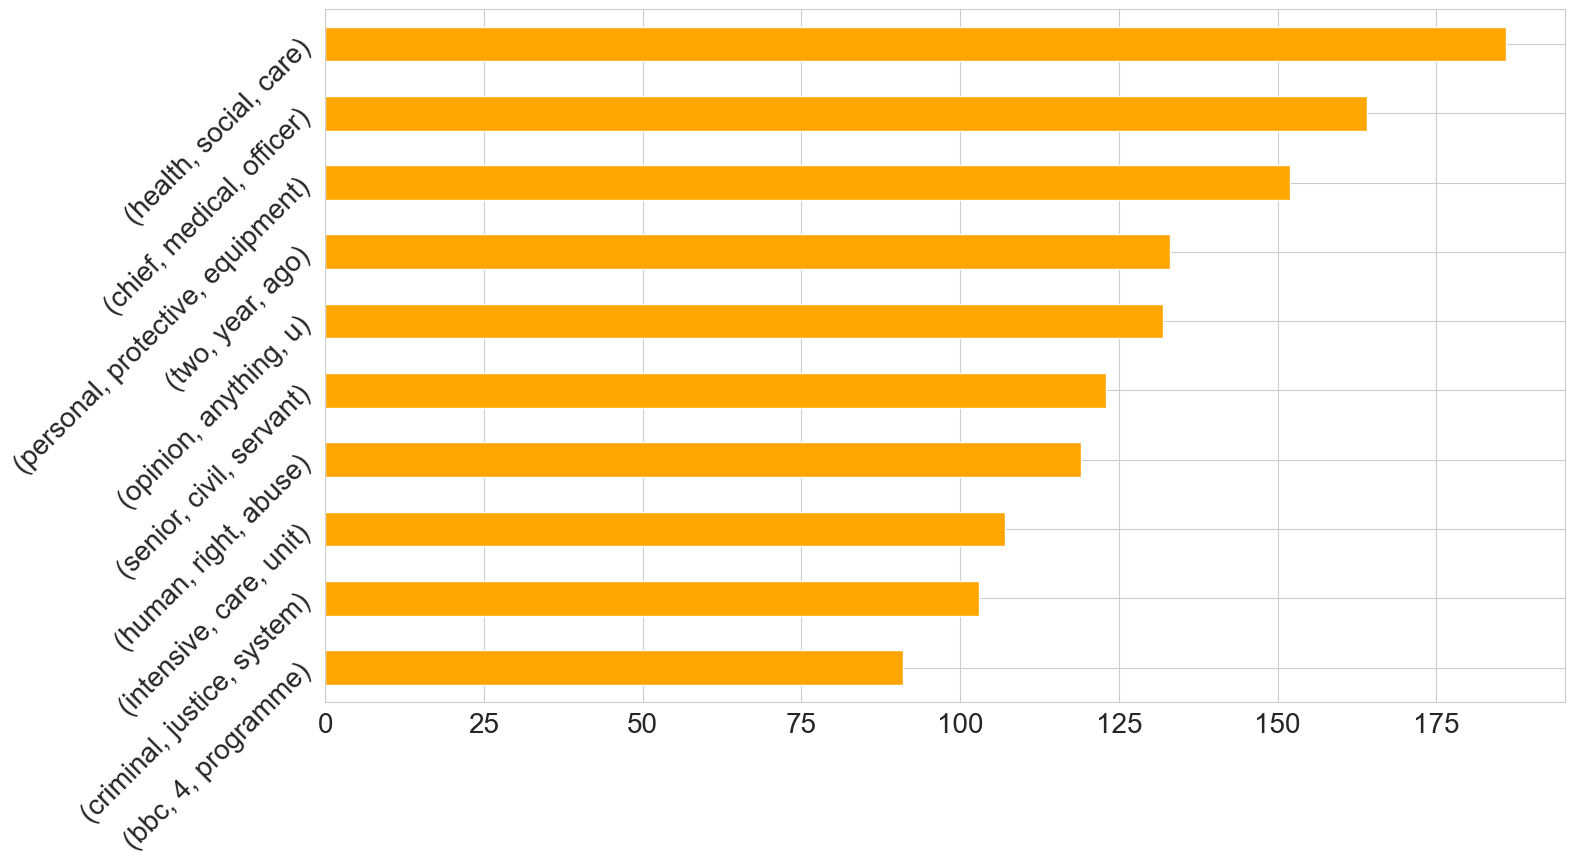

In [ ]:
plot_trigrams(df, 'ALL', '2019-12-31', '2022-03-31', top=10)

In [ ]:
sections = ['World news', 'UK news', 'Australia news', 'Opinion']
df = df[df['sectionName'].isin(sections)]
df

bodyContent  Optimistic  \
1      Twenty-two school children on their way to sta...         0.0   
3      The former prime minister Kevin Rudd is suing ...         0.0   
6      Labor rightwingers determined to execute a pow...         0.0   
7      Parliament is expected to relocate away from i...         0.0   
9      Good morning, this is Eleanor Ainge Roy bringi...         0.0   
...                                                  ...         ...   
38128  Top story: ‘They want to raze it to the ground...         0.0   
38129  A Russian couple who staged a solitary protest...         0.0   
38130  All big experiences in our lives have two real...         0.0   
38131  Until the Russian invasion of Ukraine, Hungary...         0.0   
38132  The lines for sugar in Saratov were hard not t...         0.0   

       Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  Denial  \
1           0.0         0.0          0.0      0.0  1.0      0.0     0.0   
3           0.0         0.0          0.0      0.0  0.0      0.0     0.0   
6           0.0         0.0          0.0      0.0  0.0      0.0     1.0   
7           0.0         0.0          0.0      0.0  0.0      0.0     0.0   
9           0.0         0.0          0.0      0.0  0.0      0.0     0.0   
...         ...         ...          ...      ...  ...      ...     ...   
38128       0.0         0.0          0.0      0.0  0.0      0.0     0.0   
38129       0.0         0.0          0.0      0.0  0.0      0.0     0.0   
38130       0.0         0.0          1.0      0.0  0.0      1.0     0.0   
38131       0.0         0.0          0.0      0.0  0.0      1.0     1.0   
38132       0.0         0.0          0.0      0.0  1.0      0.0     0.0   

       Official report  Joking     sectionName webPublicationDate  \
1                  1.0     0.0      World news         2018-01-31   
3                  1.0     0.0  Australia news         2018-01-31   
6                  1.0     0.0  Australia news         2018-01-31   
7                  1.0     0.0         UK news         2018-01-31   
9                  1.0     0.0  Australia news         2018-01-31   
...                ...     ...             ...                ...   
38128              1.0     0.0      World news         2022-03-23   
38129              1.0     0.0         UK news         2022-03-23   
38130              0.0     0.0         Opinion         2022-03-23   
38131              0.0     0.0      World news         2022-03-23   
38132              0.0     0.0      World news         2022-03-23   

      year_quarter  Year  
1          2018-Q1  2018  
3          2018-Q1  2018  
6          2018-Q1  2018  
7          2018-Q1  2018  
9          2018-Q1  2018  
...            ...   ...  
38128      2022-Q1  2022  
38129      2022-Q1  2022  
38130      2022-Q1  2022  
38131      2022-Q1  2022  
38132      2022-Q1  2022  

[28855 rows x 15 columns]

In [ ]:
'''start_date = '2018-01-01'
end_date = '2022-12-31'
# save world news
world_news_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\world_news_articles_2018_to_2022.csv"
wsection_names = ['World news']
filter_and_save_data(df, start_date, end_date, wsection_names, world_news_output_file_path)
# save Australia news
au_news_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\australia_news_articles_2018_to_2022.csv"
ausection_names = ['Australia news']
filter_and_save_data(df, start_date, end_date, ausection_names, au_news_output_file_path)

uk_news_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\uk_articles_2018_to_2022.csv"
ukn_names = ['UK news']
filter_and_save_data(df, start_date, end_date, ukn_names, uk_news_output_file_path)

opinion_output_file_path = r"D:\UNSW\2024T1\MATH5925\data\opinion_articles_2018_to_2022.csv"
opinion_names = ['Opinion']
filter_and_save_data(df, start_date, end_date, opinion_names, opinion_output_file_path)'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 102-103: truncated \UXXXXXXXX escape (2463152958.py, line 18)

NameError: name 'world_news_df' is not defined

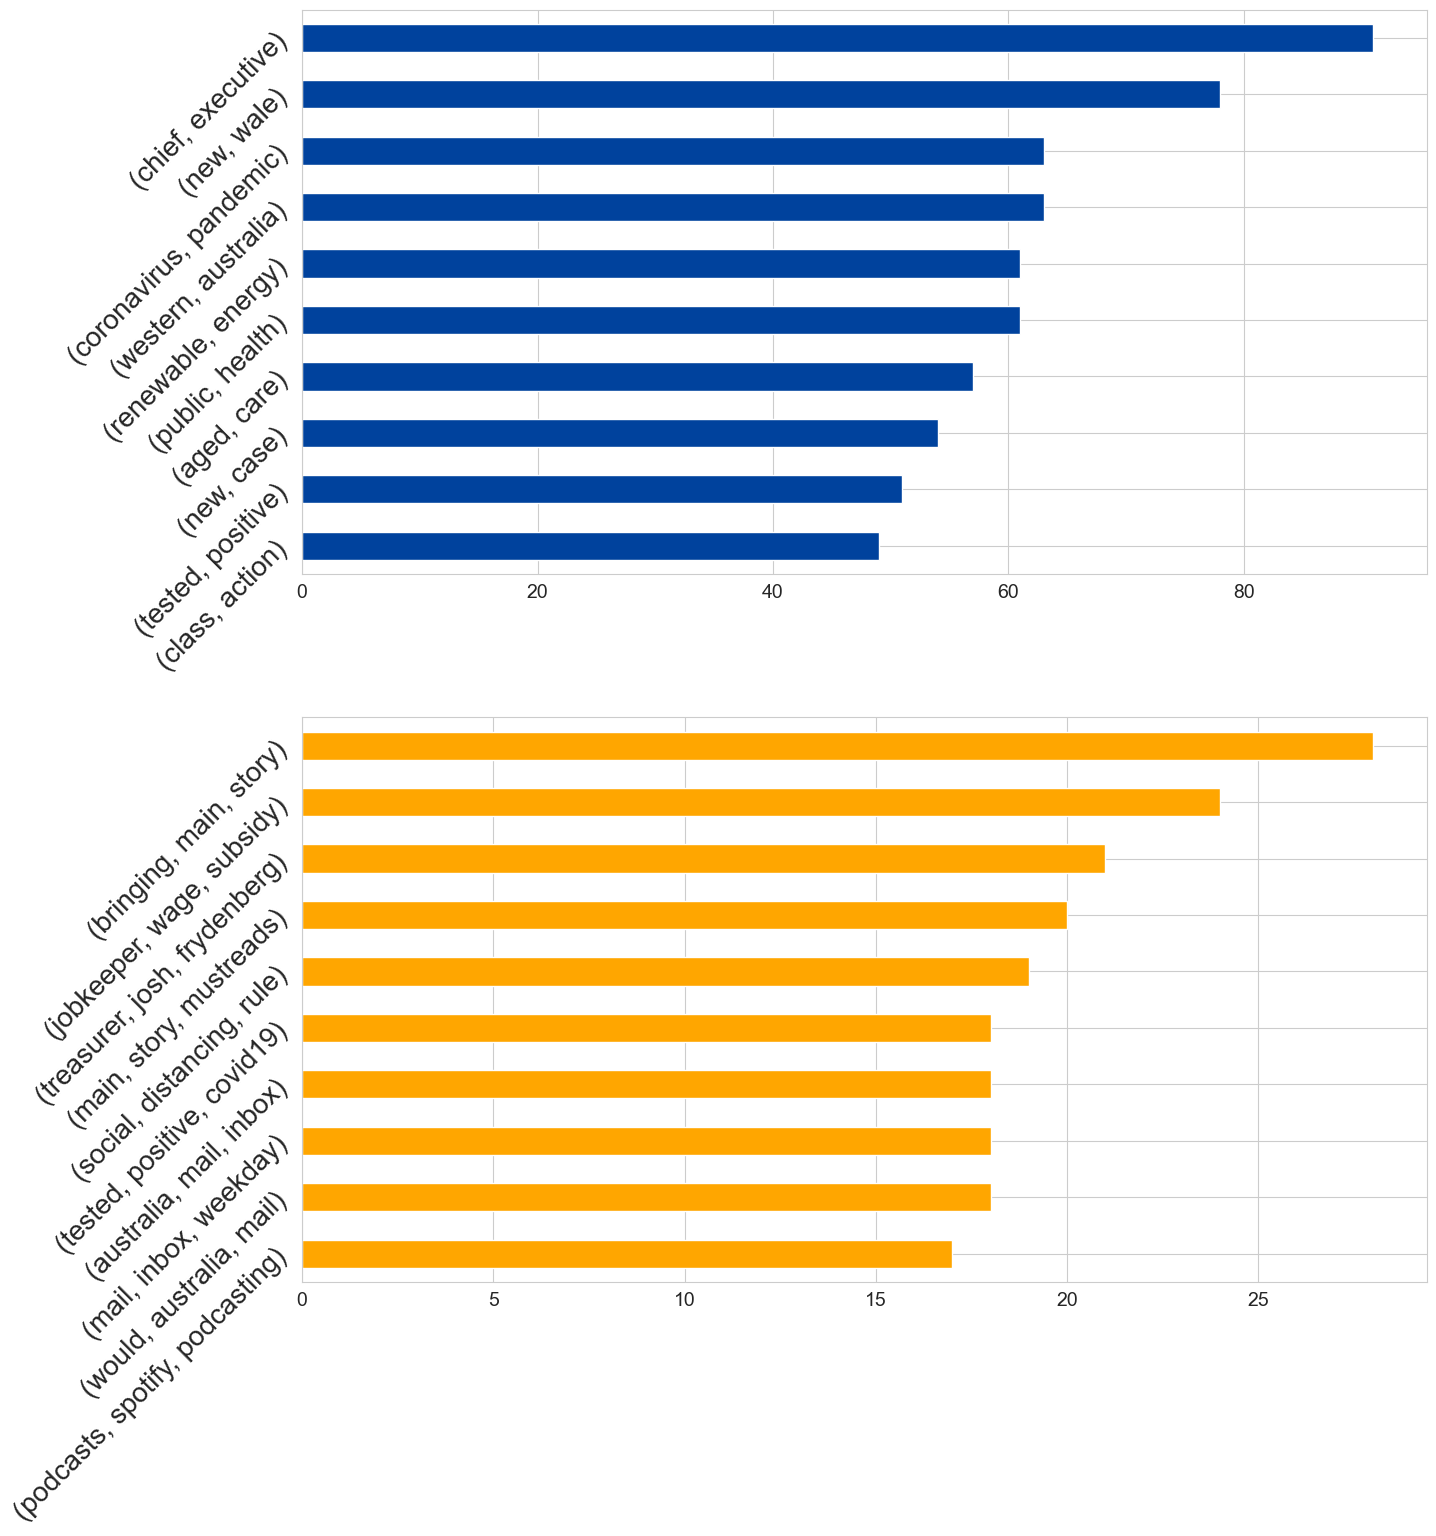

In [ ]:
plot_ngrams_for_dataset(au_news_df, 'Australia News 2020 Q2', '2020-04-01', '2020-06-30', n=[2, 3], top=10, colors=('#00429d', '#ffa600'))

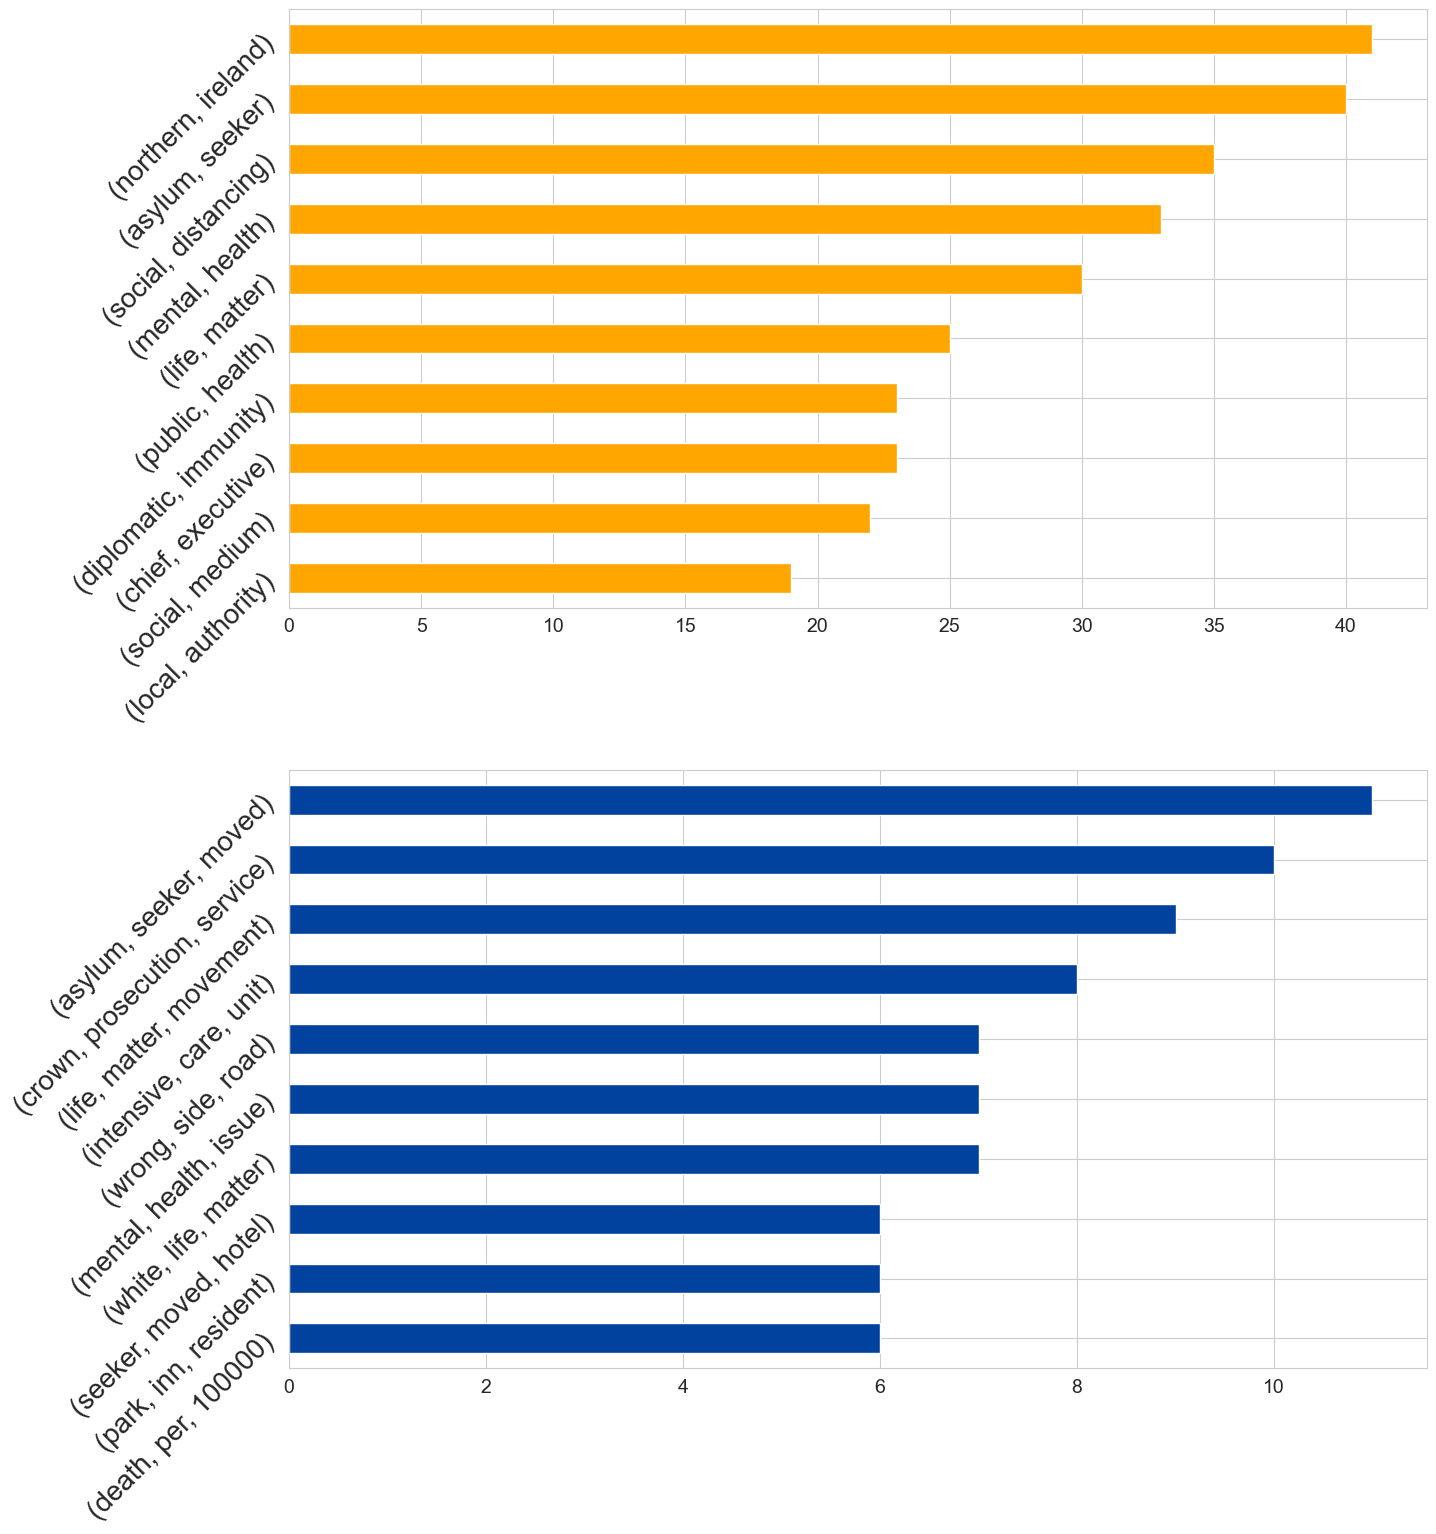

In [ ]:
plot_ngrams_for_dataset(uk_news_df, 'UK News 2020 Q2', '2020-04-01', '2020-06-30', n=[2, 3], top=10, colors=('#ffa600','#00429d'))

In [ ]:
def plot_ngrams_for_two_datasets(data1, dataset_name1, data2, dataset_name2, start_date, end_date, n=2, top=15, colors=('#00429d', '#ffa600')):
    # 设置图的总大小
    plt.figure(figsize=(15, 16))

    datasets = [(data1, dataset_name1), (data2, dataset_name2)]
    for i, (data, dataset_name) in enumerate(datasets):
        # Extract data for the specified date range
        quarterly_data = extract_specific_quarter_data(data, start_date, end_date)

        # Clean the data
        cleaned_data = clean(''.join(quarterly_data['Tweet']))

        # 计算n-grams并绘制条形图
        ngrams_series = pd.Series(nltk.ngrams(cleaned_data, n)).value_counts()[:top]

        # 创建子图；调整子图间的垂直间距
        ax = plt.subplot(2, 1, i+1)

        ngrams_series.sort_values().plot.barh(color=colors[i % len(colors)], width=0.5, ax=ax)

        # 不设置标题
        # ax.set_title(f'Top {top} {n}-grams in {dataset_name} ({start_date} to {end_date})', fontsize=18)

        # 设置刻度字体大小
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=20, rotation=45)

        # 在图下方添加指定的文本
        label = "a)" if i == 0 else "b)"
        plt.text(0.5, -0.15, f'{label}', fontsize=12, ha='center', transform=ax.transAxes)

    # 调整子图布局
    plt.tight_layout(pad=3.0)
    plt.show()

# 示例调用
plot_ngrams_for_two_datasets(au_news_df, 'Australia News 2020 Q2', uk_news_df, 'UK News 2020 Q2', '2020-04-01', '2020-06-30', n=2, top=10)

In [ ]:
'''def plot_ngrams(words, n=2, top=15, color='green'):
    dataset_name = words.name if hasattr(words, 'name') else 'Dataset'
    ngrams_series = pd.Series(nltk.ngrams(words, n)).value_counts()[:top]

    # plot
    plt.figure(figsize=(10, 6))
    ngrams_series.sort_values().plot.barh(color=color, width=0.9)
    plt.title(f'Top {top} {n}-grams in {dataset_name}')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()'''



'''def plot_ngrams_for_dataset(data, dataset_name, start_date, end_date, n=[2], top=15, colors=('#00429d', '#ffa600')):
    # Extract data for the specified date range
    quarterly_data = extract_specific_quarter_data(data, start_date, end_date)

    # Clean the data
    quarterly_data['Tweet'] = quarterly_data['Tweet'].astype(str)
    cleaned_data = clean(''.join(quarterly_data['Tweet']))

    plt.figure(figsize=(15, 16))


    for i, n_val in enumerate(n):

        ax = plt.subplot(len(n), 1, i+1)

        # 计算n-grams并绘制条形图
        ngrams_series = pd.Series(nltk.ngrams(cleaned_data, n_val)).value_counts()[:top]
        ngrams_series.sort_values().plot.barh(color=colors[i % len(colors)], width=0.5, ax=ax)

        # Set tick parameters without titles
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=20, rotation=45)


    plt.tight_layout(pad=3.0)
    plt.show()'''

'''def extract_and_clean_ngrams(data, n, top):

    cleaned_data = clean(''.join(data['Tweet']))
    ngrams_series = pd.Series(nltk.ngrams(cleaned_data, n)).value_counts()[:top]
    return ngrams_series.sort_values()'''

'''def compare_ngrams_for_datasets(dataset1, name1, dataset2, name2, start_date, end_date, n=2, top=15, colors=('#00429d', '#ffa600')):
    import matplotlib.pyplot as plt

    # 提取并清洗两个数据集的n-grams
    ngrams1 = extract_and_clean_ngrams(extract_specific_quarter_data(dataset1, start_date, end_date), n, top)
    ngrams2 = extract_and_clean_ngrams(extract_specific_quarter_data(dataset2, start_date, end_date), n, top)

    # 绘制图表
    fig, ax = plt.subplots(figsize=(15, 8))

    # 数据合并为DataFrame，准备绘制
    df = pd.DataFrame({
        name1: ngrams1,
        name2: ngrams2
    })

    # 绘制barh图
    df.plot.barh(ax=ax, color=colors, width=0.5)

    # 设置标题和标签
    ax.set_title(f'Top {top} {n}-grams comparison between {name1} and {name2} ({start_date} to {end_date})', fontsize=18)
    ax.set_xlabel('Frequency', fontsize=14)
    ax.set_ylabel('N-grams', fontsize=14)
    ax.legend()

    plt.tight_layout()
    plt.show()'''